# Causal Inference with Multilevel Models: The Electric Company Example

This notebook reproduces the example from **Chapter 23** of Gelman and Hill's *"Data Analysis Using Regression and Multilevel/Hierarchical Models"* (see page 529).

## Context

In the 1970s, an educational television show called **"The Electric Company"** was produced to help children learn to read. An experiment was conducted to estimate the causal effect of watching the show on reading test scores.

## Study Design

The design involved **paired classrooms** in schools across 4 grades:
-   **Pairs**: Classrooms were matched into pairs (e.g., two 1st grade classes in the same school).
-   **Treatment**: Within each pair, one classroom was randomly assigned to the **treatment group** (watched the show) and the other to the **control group** (did not watch).
-   **Outcome**: Reading test scores at the end of the year (`post_test`), controlling for pre-test scores (`pre_test`).

This **paired randomized design** is powerful because it controls for school-level and community-level confounders by design. However, the data structure is **clustered**, which motivates the use of multilevel models.

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import preliz as pz
import pymc as pm
import pytensor.tensor as pt
from marginaleffects import datagrid
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Read Data

In [2]:
data_path = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/ElectricCompany/data/electric.csv"
raw_df = pl.read_csv(data_path).drop(["supp", ""]).sort(["grade", "pair_id"])

raw_df.head()

shape: (5, 5)
┌───────────┬──────────┬───────┬───────────┬─────────┐
│ post_test ┆ pre_test ┆ grade ┆ treatment ┆ pair_id │
│ ---       ┆ ---      ┆ ---   ┆ ---       ┆ ---     │
│ f64       ┆ f64      ┆ i64   ┆ i64       ┆ i64     │
╞═══════════╪══════════╪═══════╪═══════════╪═════════╡
│ 48.9      ┆ 13.8     ┆ 1     ┆ 1         ┆ 1       │
│ 52.3      ┆ 12.3     ┆ 1     ┆ 0         ┆ 1       │
│ 70.5      ┆ 16.5     ┆ 1     ┆ 1         ┆ 2       │
│ 55.0      ┆ 14.4     ┆ 1     ┆ 0         ┆ 2       │
│ 89.7      ┆ 18.5     ┆ 1     ┆ 1         ┆ 3       │
└───────────┴──────────┴───────┴───────────┴─────────┘

## Exploratory Data Analysis

Before modeling, it's crucial to visualize the data. Since the design relies on paired classrooms, we should inspect the distribution of test scores across grades and pairs to understand the variability we need to model.

## Data Preprocessing

In [3]:
numeric_features = ["pre_test", "post_test"]
ordinal_features = ["grade", "pair_id"]

preprocessor = ColumnTransformer(
    [
        ("num", StandardScaler(), numeric_features),
        ("ord", OrdinalEncoder(dtype=int), ordinal_features),
    ],
    remainder="passthrough",
).set_output(transform="polars")


df = preprocessor.fit_transform(raw_df)
df.columns = [col.split("__")[-1] for col in df.columns]

df.head()

shape: (5, 5)
┌───────────┬───────────┬───────┬─────────┬───────────┐
│ pre_test  ┆ post_test ┆ grade ┆ pair_id ┆ treatment │
│ ---       ┆ ---       ┆ ---   ┆ ---     ┆ ---       │
│ f64       ┆ f64       ┆ i64   ┆ i64     ┆ i64       │
╞═══════════╪═══════════╪═══════╪═════════╪═══════════╡
│ -1.726248 ┆ -2.724052 ┆ 0     ┆ 0       ┆ 1         │
│ -1.770568 ┆ -2.532096 ┆ 0     ┆ 0       ┆ 0         │
│ -1.646472 ┆ -1.504567 ┆ 0     ┆ 1       ┆ 1         │
│ -1.70852  ┆ -2.37966  ┆ 0     ┆ 1       ┆ 0         │
│ -1.587379 ┆ -0.42058  ┆ 0     ┆ 2       ┆ 1         │
└───────────┴───────────┴───────┴─────────┴───────────┘

In [4]:
x_columns = ["pre_test"]
x_df = df[x_columns]

x_df.head()

shape: (5, 1)
┌───────────┐
│ pre_test  │
│ ---       │
│ f64       │
╞═══════════╡
│ -1.726248 │
│ -1.770568 │
│ -1.646472 │
│ -1.70852  │
│ -1.587379 │
└───────────┘

In [5]:
n_grades = len(preprocessor["ord"].categories_[ordinal_features.index("grade")])
n_pairs = len(preprocessor["ord"].categories_[ordinal_features.index("pair_id")])

coords = {
    # covariates
    "covariates": x_df.columns,
    # grade
    "grade": preprocessor["ord"].categories_[ordinal_features.index("grade")],
    # object categories (groups)
    "pair_id": preprocessor["ord"].categories_[ordinal_features.index("pair_id")],
    # index
    "obs_idx": np.arange(len(df)),
}

## Model Specification

### Motivation: Why Multilevel?

The data is **clustered** into pairs of classrooms. Observations within the same pair (same school/grade) are likely correlated due to shared unobserved factors like school quality, neighborhood demographics, or teacher characteristics. Ignoring this structure would violate the independence assumption of standard regression.

To estimate the causal effect, we have two main strategies to handle this clustering:

### Alternative 1: Fixed Effects (FE)

We could include a **dummy variable (intercept) for every pair**.
-   **Pros**: This controls for **ALL** time-invariant pair-level unobserved confounders. It effectively "closes back doors" related to the school or neighborhood (see *The Effect*, Chapter 16).
-   **Cons**: It consumes a massive number of degrees of freedom ($N/2$ parameters just for intercepts!). With many small groups (pairs), this can lead to noisy and inefficient estimates.

### Alternative 2: Random Effects (RE) / Hierarchical Intercepts

We model the pair intercepts as coming from a common distribution, e.g., $\alpha_{j} \sim N(\mu, \sigma)$.
-   **Pros**: This uses **partial pooling**. The model learns the variance $\sigma$ and "shrinks" noisy pair estimates toward the global mean. It is far more efficient than FE.

#### Addressing "The Effect" (Advanced Random Effects)

A common critique in econometrics (often citing the Hausman test) is that Random Effects models assume the group effect is **uncorrelated** with the predictors ($Cov(\alpha_j, X) = 0$). If this assumption is violated (e.g., richer schools have both higher baseline scores and different treatment effects), standard RE estimates can be biased.

However, as discussed in *The Effect* (Huntington-Klein, Chapter 16, "Advanced Random Effects"), modern multilevel modeling views this not just as a rigid assumption, but as a modeling choice. We can explicitly model these relationships if needed.

**Why RE is valid here:**
Crucially, in this experiment, **treatment was randomized WITHIN pairs**.
-   Because of randomization, the treatment assignment is **uncorrelated** with the pair's baseline characteristics (the "random effect") by definition.
-   Therefore, the dreaded "endogeneity" problem of RE does not apply to the treatment variable.

We can thus use a **Hierarchical Intercept Model** to efficiently control for pair-level heterogeneity and obtain correct standard errors without the heavy penalty of Fixed Effects.

$$
\begin{align}
\text{post\_test}_i &\sim N(\mu_i, \sigma_y) \\
\mu_i &= \alpha_{\text{pair}[i]} + \beta_T \cdot T_i + \beta_x \cdot \text{pre\_test}_i \\
\alpha_j &\sim N(\mu_\alpha, \sigma_\alpha)
\end{align}
$$

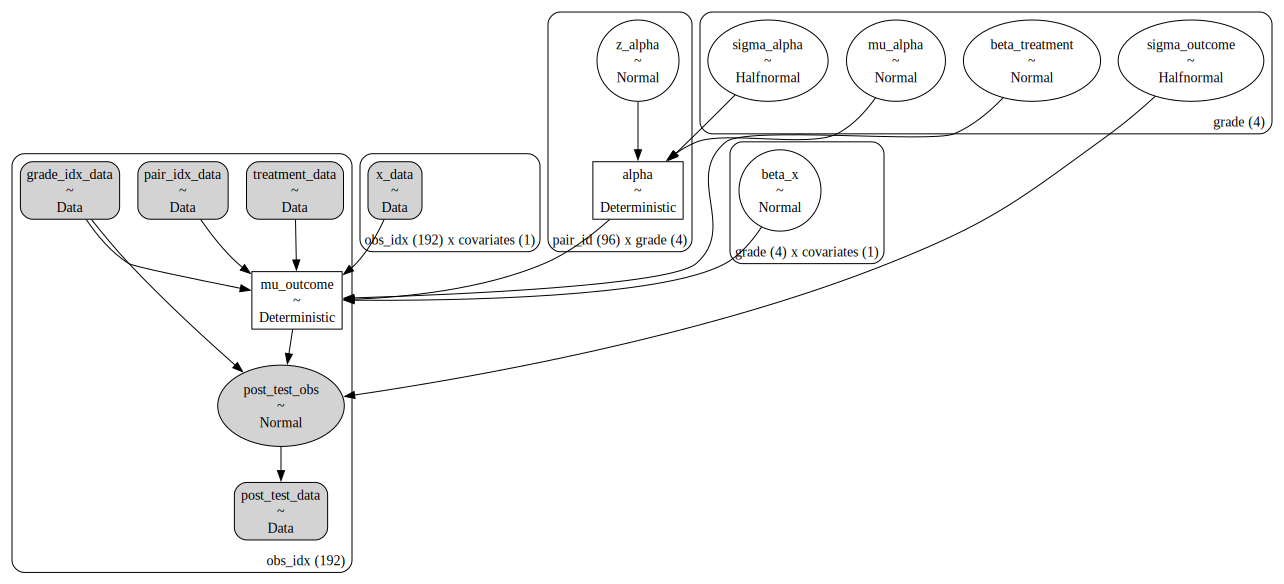

In [6]:
with pm.Model(coords=coords) as model:
    # --- Data Containers ---
    # covariates
    x_data = pm.Data("x_data", x_df, dims=("obs_idx", "covariates"))
    # grade
    grade_idx_data = pm.Data("grade_idx_data", df["grade"].to_numpy(), dims="obs_idx")
    # object categories
    pair_idx_data = pm.Data("pair_idx_data", df["pair_id"].to_numpy(), dims="obs_idx")
    # treatment
    treatment_data = pm.Data(
        "treatment_data", df["treatment"].to_numpy(), dims=("obs_idx")
    )
    # outcome
    post_test_data = pm.Data(
        "post_test_data", df["post_test"].to_numpy(), dims="obs_idx"
    )

    # --- Priors ---
    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=1, dims=("grade"))
    sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=1, dims=("grade"))
    z_alpha = pm.Normal("z_alpha", mu=0, sigma=1, dims=("pair_id", "grade"))

    beta_treatment = pm.Normal("beta_treatment", mu=0, sigma=1, dims=("grade"))
    beta_x = pm.Normal("beta_x", mu=0, sigma=1, dims=("grade", "covariates"))

    sigma_outcome = pm.HalfNormal("sigma_outcome", sigma=1, dims=("grade"))

    # --- Parametrization ---
    # Non-centered parametrization for the random intercepts
    alpha = pm.Deterministic(
        "alpha", mu_alpha + z_alpha * sigma_alpha, dims=("pair_id", "grade")
    )

    mu_outcome = pm.Deterministic(
        "mu_outcome",
        alpha[pair_idx_data, grade_idx_data]
        + beta_treatment[grade_idx_data] * treatment_data
        + (beta_x[grade_idx_data] * x_data).sum(axis=-1),
        dims=("obs_idx"),
    )

    # --- Likelihood ---
    pm.Normal(
        "post_test_obs",
        mu=mu_outcome,
        sigma=sigma_outcome[grade_idx_data],
        observed=post_test_data,
        dims="obs_idx",
    )


pm.model_to_graphviz(model)

## Prior Predictive Check

In [7]:
with model:
    idata = pm.sample_prior_predictive()

Sampling: [beta_treatment, beta_x, mu_alpha, post_test_obs, sigma_alpha, sigma_outcome, z_alpha]


Text(0.5, 1.02, 'Prior Predictive Check')

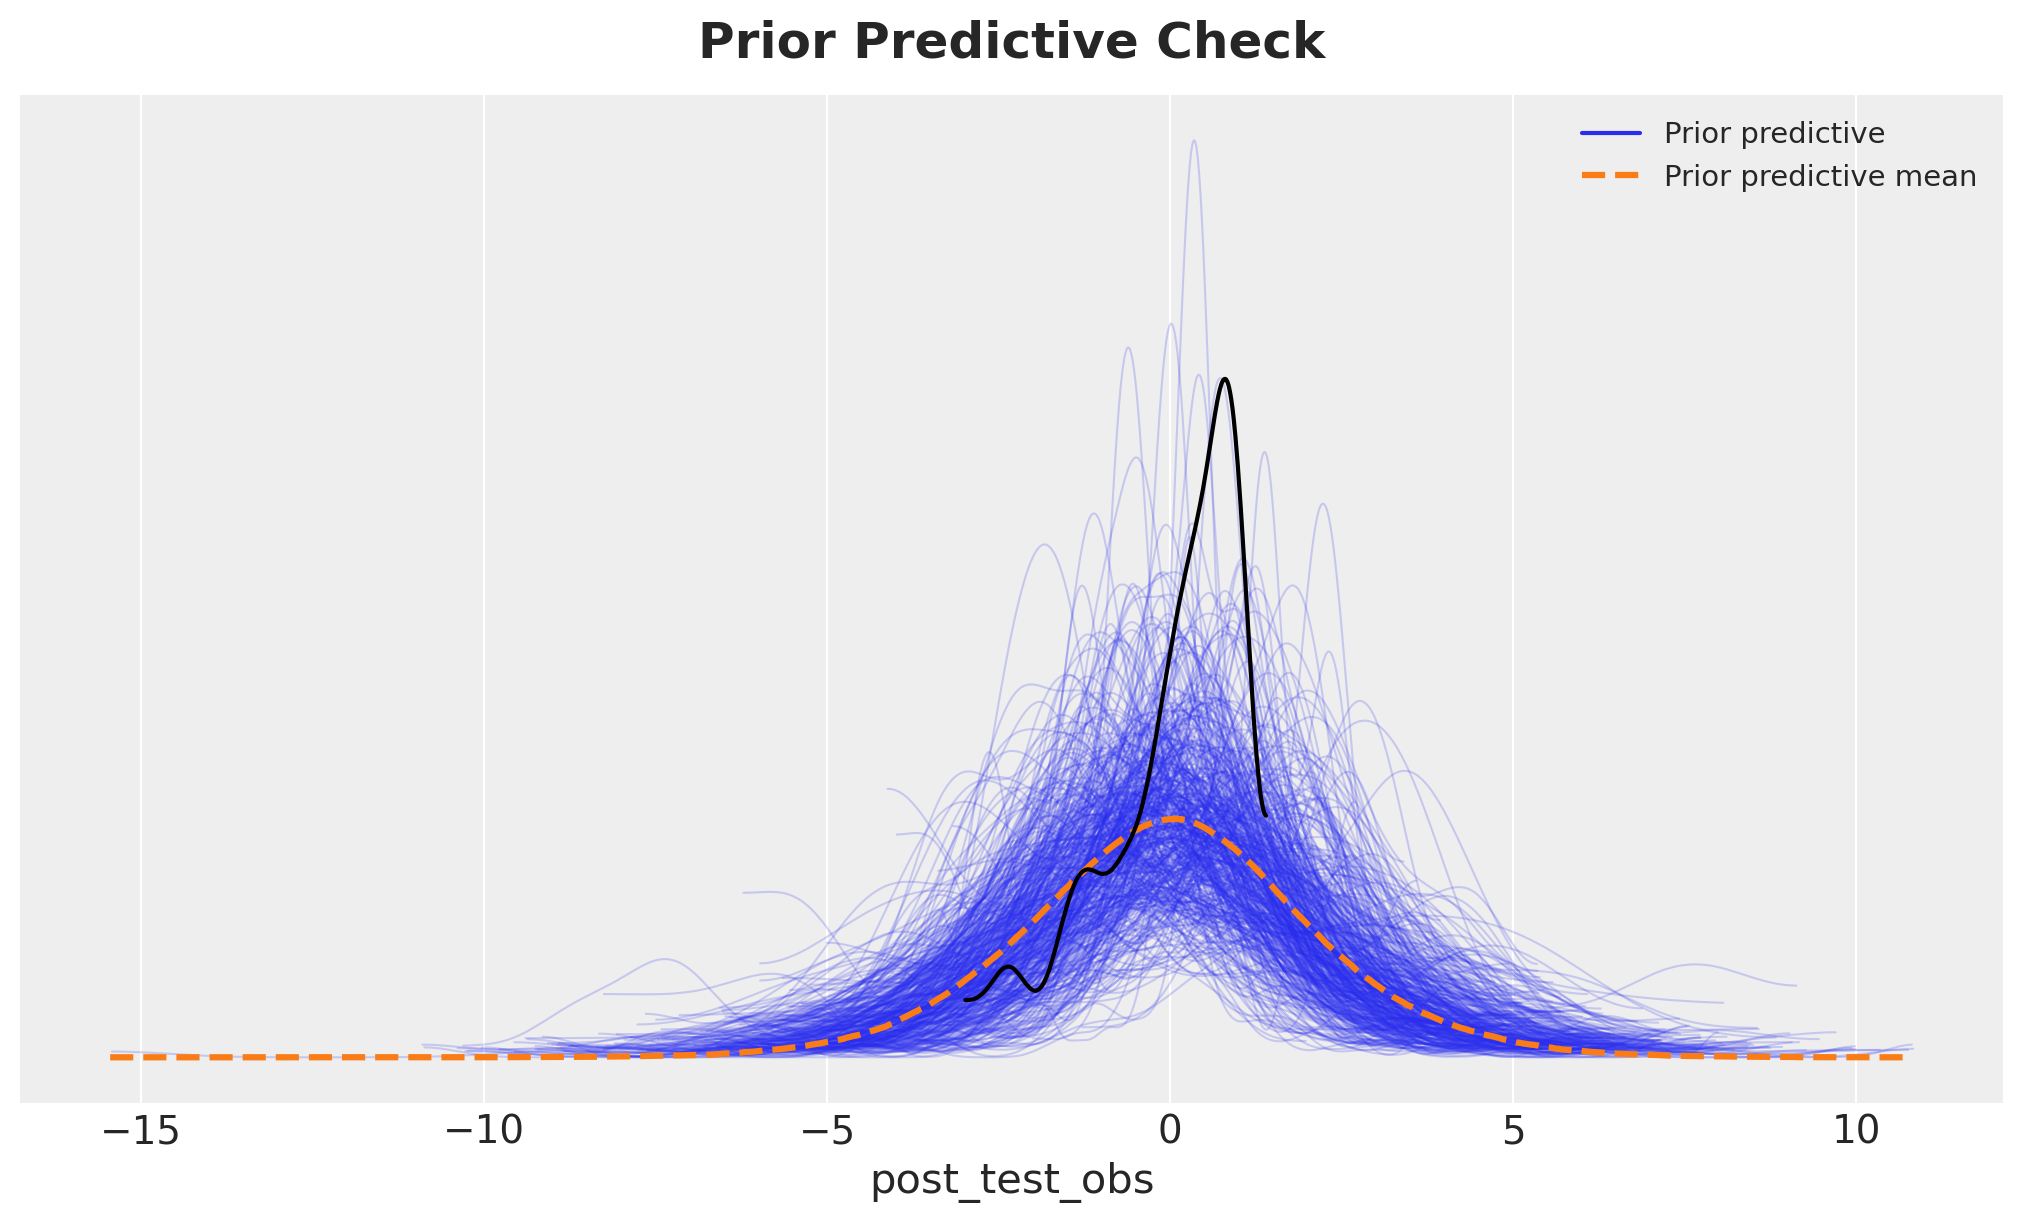

In [8]:
fig, ax = plt.subplots()
az.plot_ppc(idata, group="prior", ax=ax)
az.plot_dist(df["post_test"].to_numpy(), color="black", ax=ax)
ax.set_title("Prior Predictive Check", fontsize=18, fontweight="bold", y=1.02)

## Posterior Inference

In [9]:
with model:
    idata.extend(
        pm.sample(
            tune=1_500,
            draws=1_000,
            target_accept=0.9,
            chains=4,
            nuts_sampler="numpyro",
        )
    )

    idata.extend(pm.sample_posterior_predictive(idata))

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Sampling: [post_test_obs]


Output()

## Model Diagnostics

In [10]:
idata["sample_stats"]["diverging"].sum().item()

0

In [11]:
az.summary(
    idata,
    var_names=[
        "beta_treatment",
        "beta_x",
        "mu_alpha",
        "sigma_alpha",
        "sigma_outcome",
    ],
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta_treatment[1]    0.472  0.141   0.218    0.747      0.002    0.003   
beta_treatment[2]    0.231  0.058   0.126    0.344      0.001    0.001   
beta_treatment[3]    0.107  0.043   0.024    0.185      0.001    0.001   
beta_treatment[4]    0.094  0.035   0.031    0.161      0.000    0.001   
beta_x[1, pre_test]  1.495  0.520   0.521    2.435      0.010    0.008   
beta_x[2, pre_test]  1.554  0.113   1.325    1.745      0.002    0.002   
beta_x[3, pre_test]  1.308  0.081   1.161    1.465      0.002    0.001   
beta_x[4, pre_test]  1.274  0.090   1.098    1.435      0.002    0.002   
mu_alpha[1]          0.880  0.869  -0.794    2.411      0.016    0.013   
mu_alpha[2]         -0.150  0.056  -0.251   -0.044      0.001    0.001   
mu_alpha[3]         -0.400  0.066  -0.530   -0.286      0.001    0.001   
mu_alpha[4]         -0.459  0.090  -0.630   -0.287      0.002    0.002   
sigma_alpha[1]       0.631  0.150   0.370    0.918      0.006    0.008   
sigma_alpha[2]       0.224  0.049   0.137    0.322      0.001    0.001   
sigma_alpha[3]       0.052  0.032   0.000    0.105      0.001    0.000   
sigma_alpha[4]       0.063  0.032   0.000    0.112      0.001    0.001   
sigma_outcome[1]     0.464  0.089   0.319    0.633      0.003    0.005   
sigma_outcome[2]     0.226  0.030   0.173    0.285      0.001    0.001   
sigma_outcome[3]     0.134  0.019   0.100    0.170      0.000    0.000   
sigma_outcome[4]     0.112  0.017   0.079    0.143      0.000    0.000   

                     ess_bulk  ess_tail  r_hat  
beta_treatment[1]      6014.0    2857.0    1.0  
beta_treatment[2]      4795.0    2982.0    1.0  
beta_treatment[3]      5207.0    2637.0    1.0  
beta_treatment[4]      6057.0    2853.0    1.0  
beta_x[1, pre_test]    2901.0    2691.0    1.0  
beta_x[2, pre_test]    2724.0    2772.0    1.0  
beta_x[3, pre_test]    2849.0    2830.0    1.0  
beta_x[4, pre_test]    2374.0    2514.0    1.0  
mu_alpha[1]            2844.0    2762.0    1.0  
mu_alpha[2]            2541.0    2693.0    1.0  
mu_alpha[3]            2666.0    2360.0    1.0  
mu_alpha[4]            2425.0    2502.0    1.0  
sigma_alpha[1]          774.0     620.0    1.0  
sigma_alpha[2]         1199.0    1194.0    1.0  
sigma_alpha[3]         1250.0    1801.0    1.0  
sigma_alpha[4]          754.0    1162.0    1.0  
sigma_outcome[1]       1007.0     671.0    1.0  
sigma_outcome[2]       1536.0    1955.0    1.0  
sigma_outcome[3]       2494.0    2558.0    1.0  
sigma_outcome[4]       1195.0    2196.0    1.0

Text(0.5, 1.02, 'Model Trace')

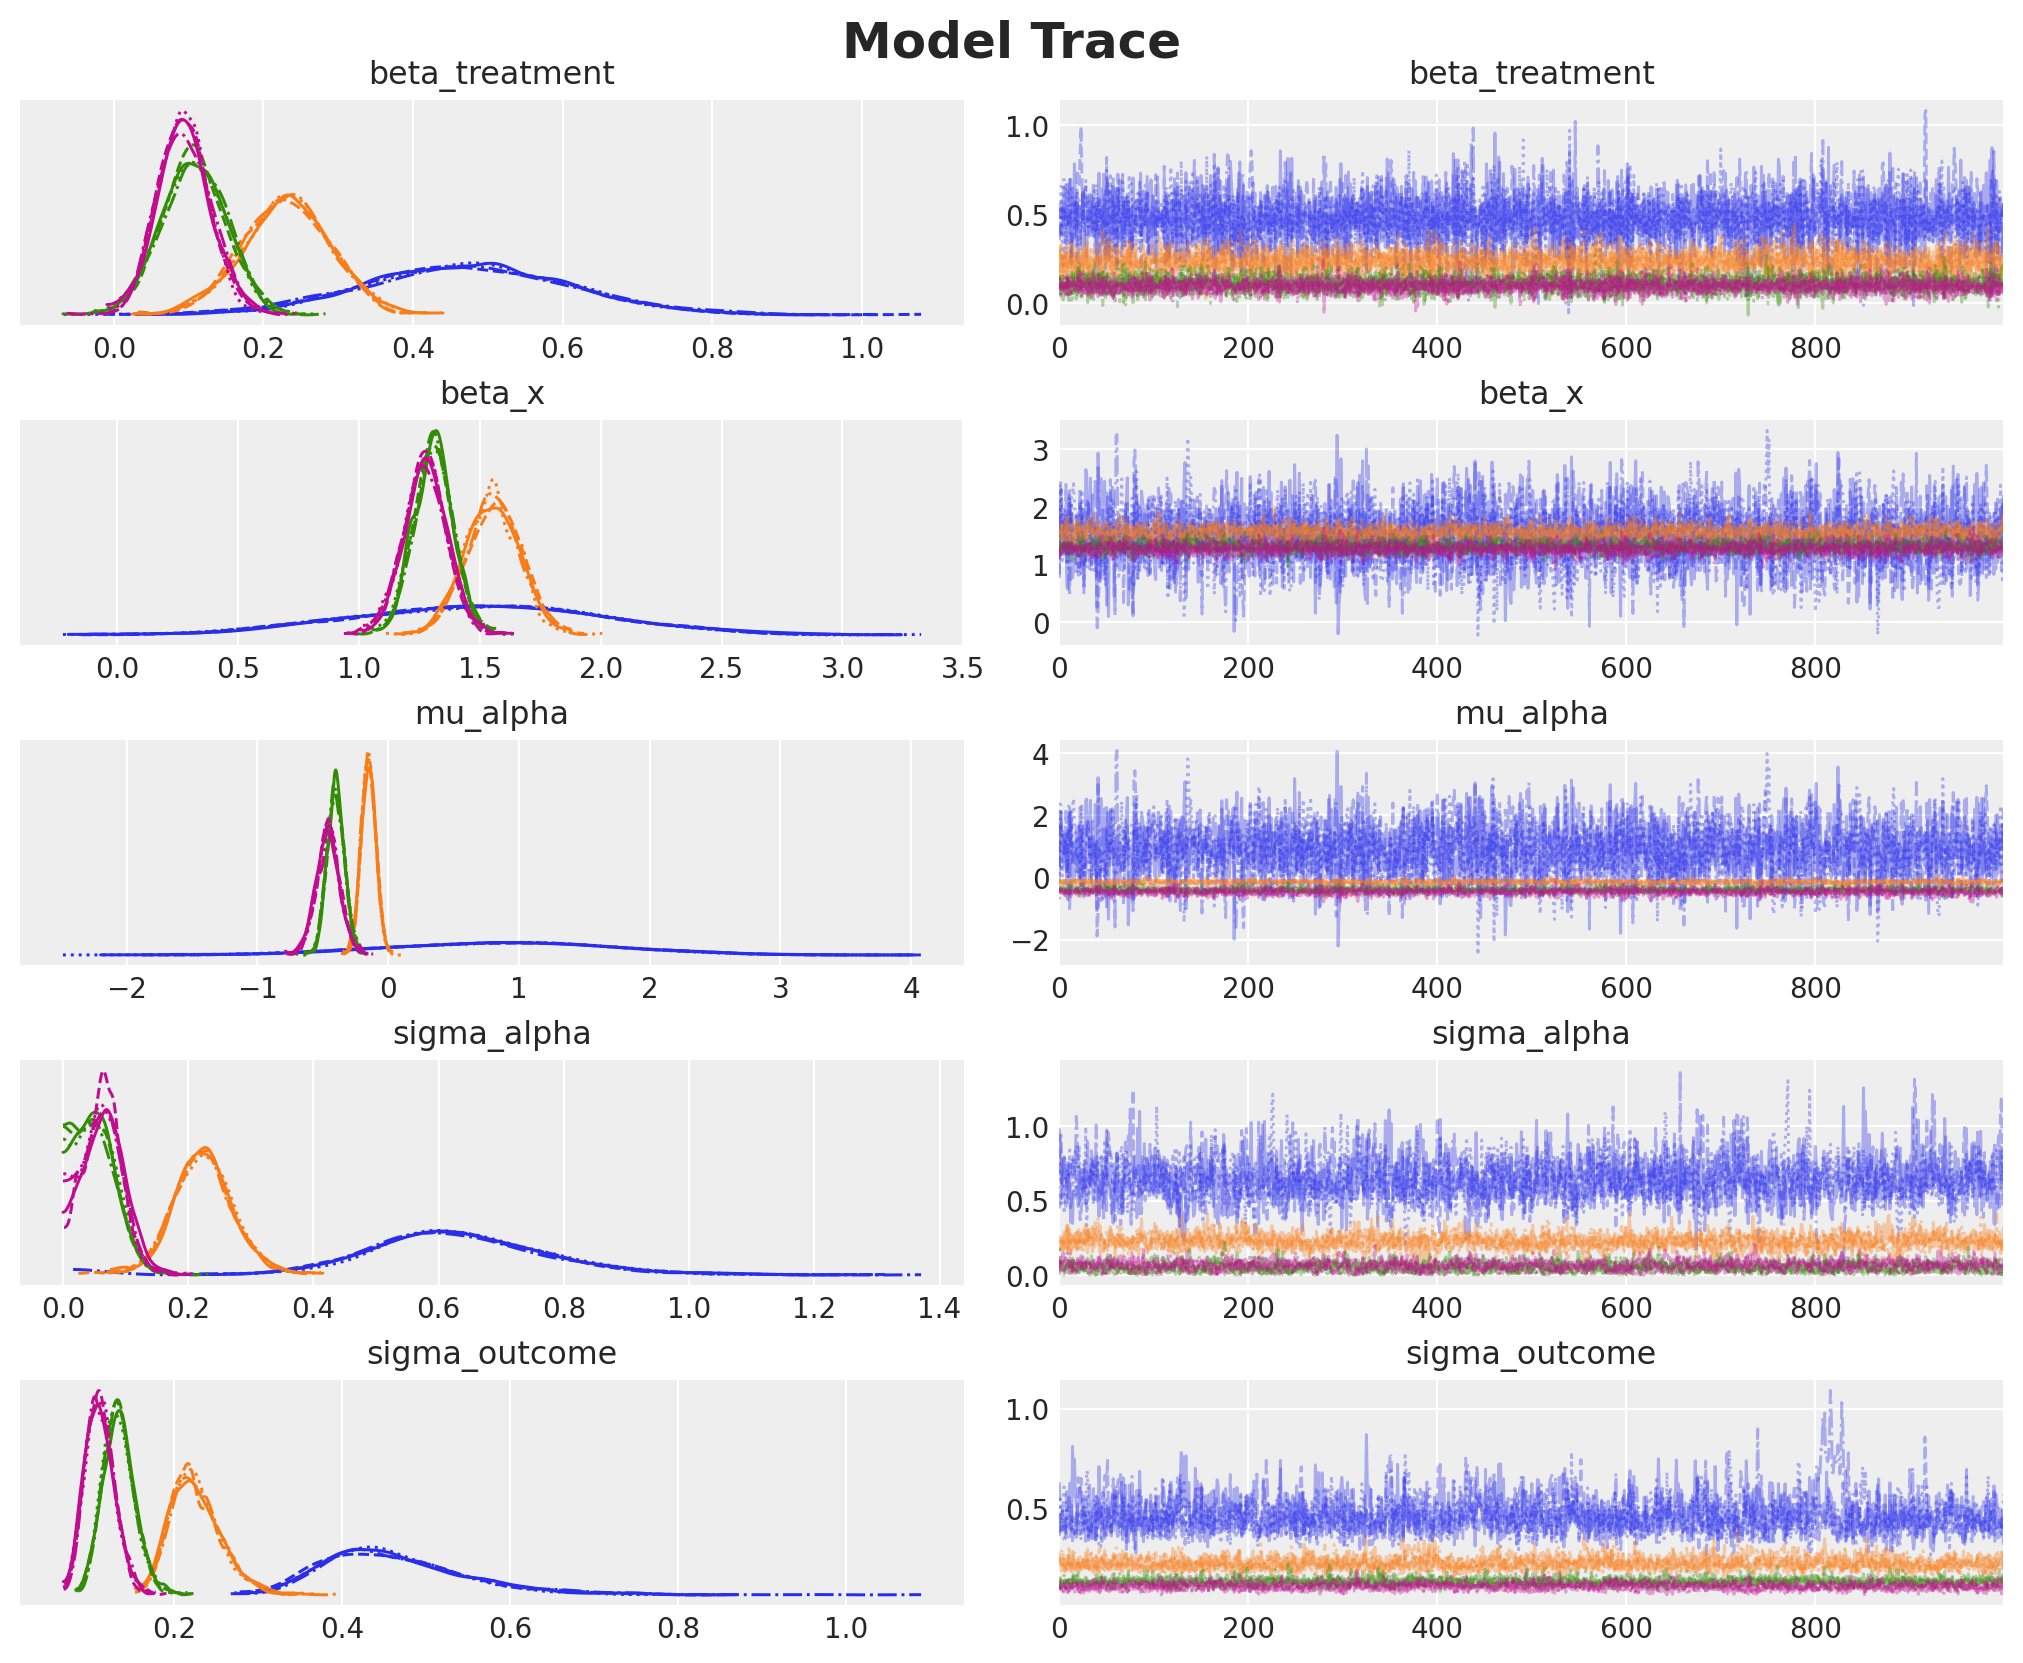

In [12]:
axes = az.plot_trace(
    idata,
    var_names=[
        "beta_treatment",
        "beta_x",
        "mu_alpha",
        "sigma_alpha",
        "sigma_outcome",
    ],
    figsize=(10, 8),
)


plt.gcf().suptitle("Model Trace", fontsize=18, fontweight="bold", y=1.02)

Text(0.5, 1.02, 'Posterior Predictive Check')

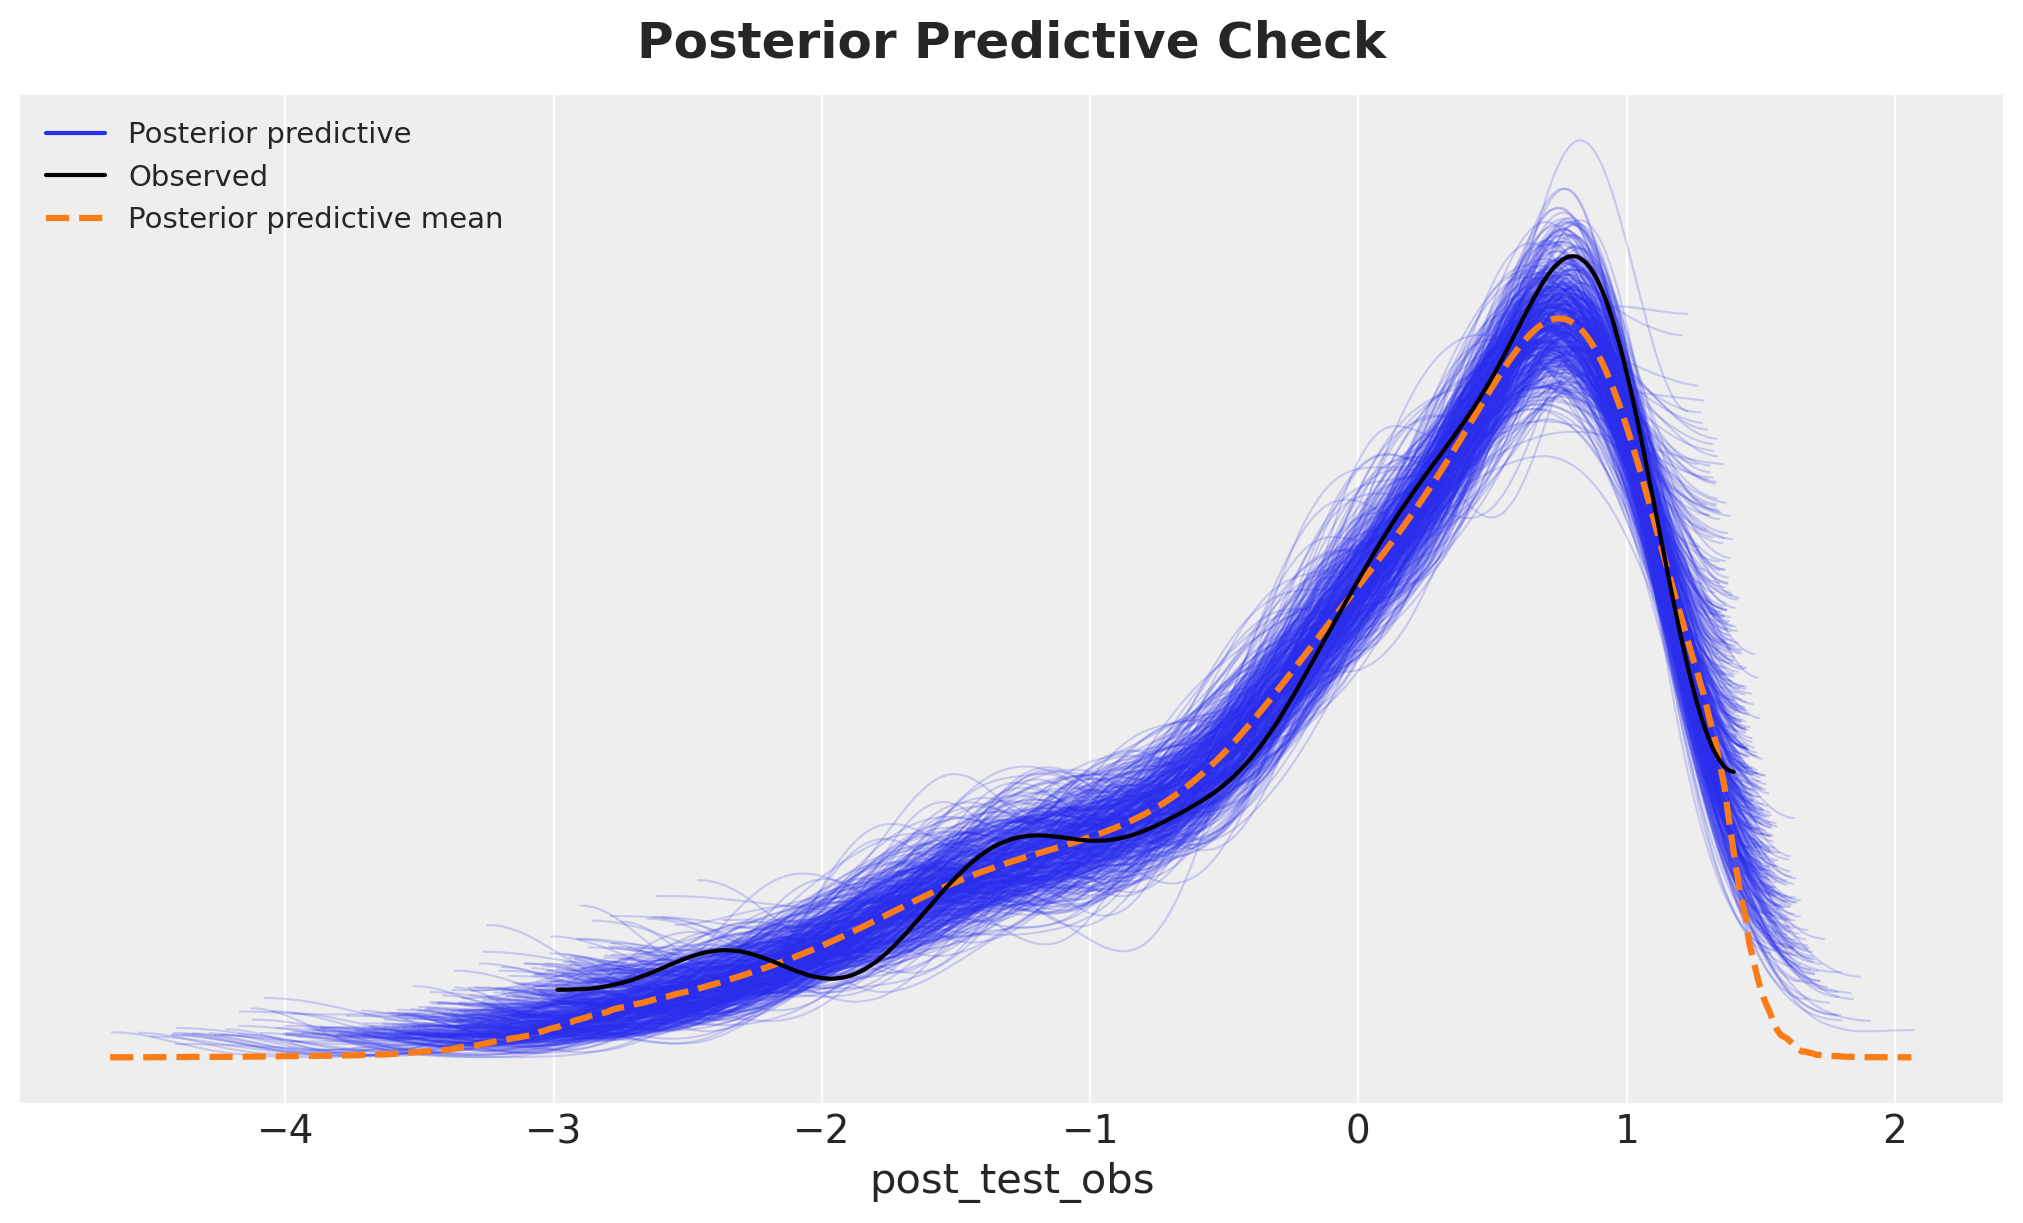

In [13]:
fig, ax = plt.subplots()
az.plot_ppc(idata, group="posterior", num_pp_samples=500, ax=ax)
ax.set_title("Posterior Predictive Check", fontsize=18, fontweight="bold", y=1.02)

## Treatment Effect Estimates

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

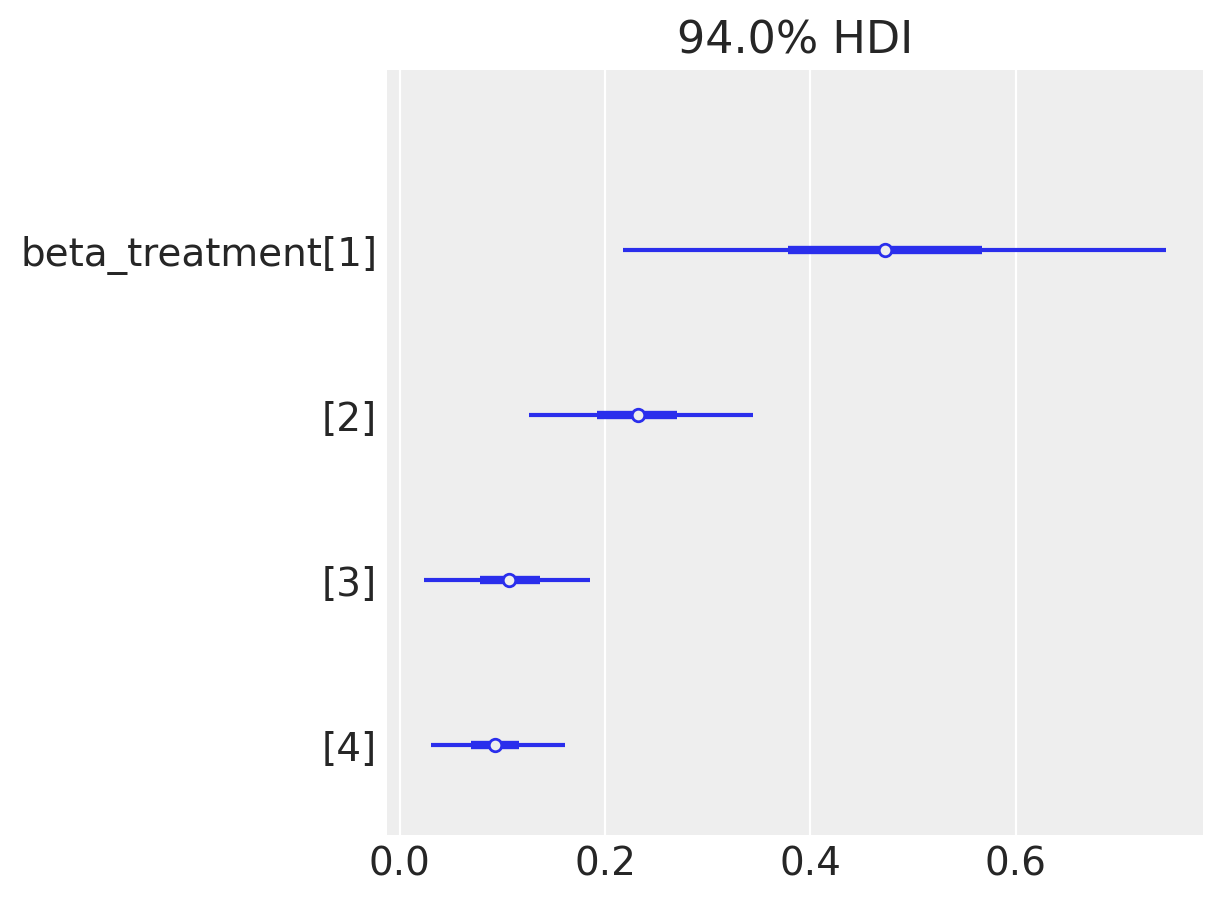

In [14]:
az.plot_forest(idata, combined=True, var_names=["beta_treatment"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

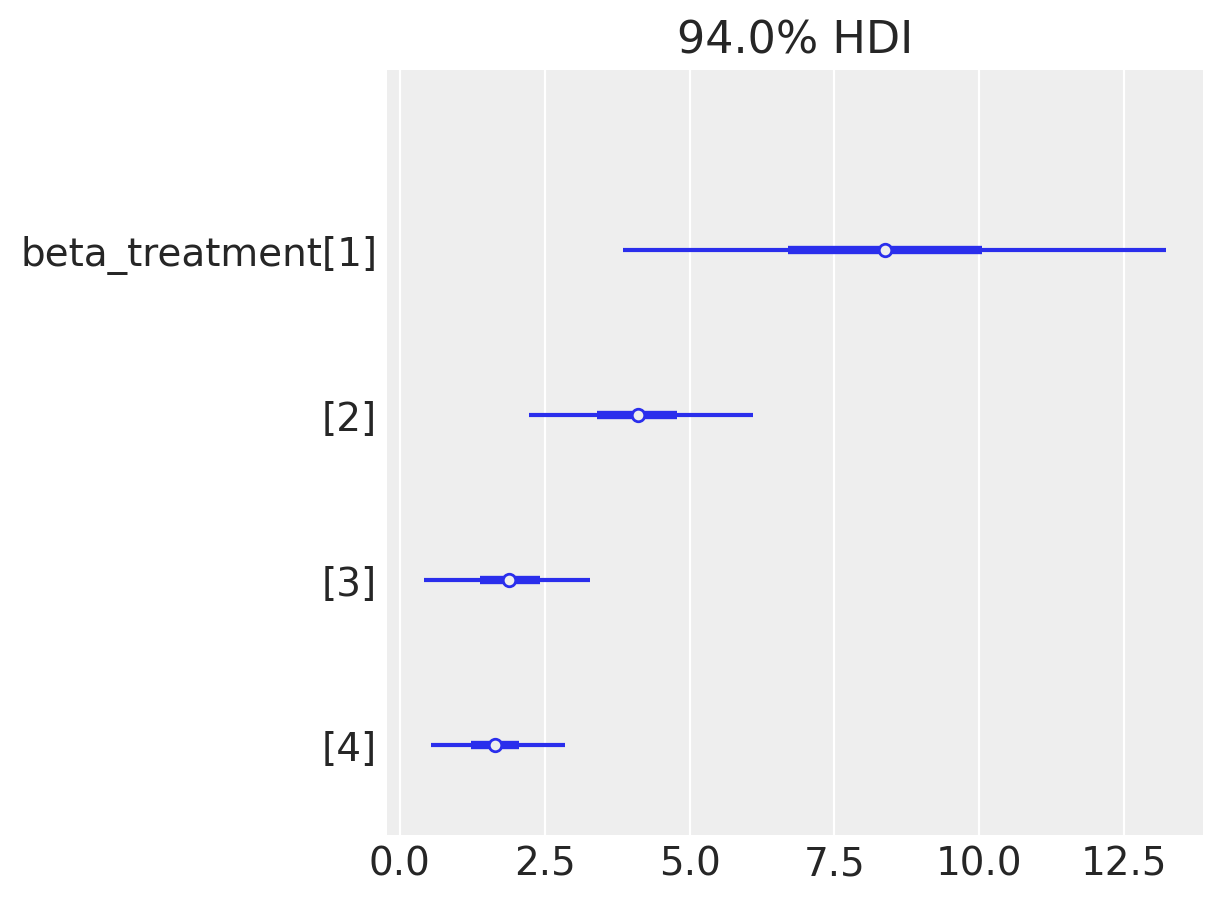

In [15]:
az.plot_forest(
    idata["posterior"]["beta_treatment"]
    * preprocessor["num"].scale_[numeric_features.index("post_test")],
    combined=True,
)

## Custom Grids

In [16]:
raw_df_control_grid = datagrid(
    newdata=raw_df,
    treatment=0,
    grade=preprocessor["ord"].categories_[ordinal_features.index("grade")],
    pair_id=preprocessor["ord"].categories_[ordinal_features.index("pair_id")],
    pre_test=np.linspace(raw_df["pre_test"].min(), raw_df["pre_test"].max(), 10),
)

df_control_grid = preprocessor.transform(raw_df_control_grid)
df_control_grid.columns = [col.split("__")[-1] for col in df_control_grid.columns]
x_df_control_grid = df_control_grid[x_columns]

raw_df_treatment_grid = datagrid(
    newdata=raw_df,
    treatment=1,
    grade=preprocessor["ord"].categories_[ordinal_features.index("grade")],
    pair_id=preprocessor["ord"].categories_[ordinal_features.index("pair_id")],
    pre_test=np.linspace(raw_df["pre_test"].min(), raw_df["pre_test"].max(), 10),
)

df_treatment_grid = preprocessor.transform(raw_df_treatment_grid)
df_treatment_grid.columns = [col.split("__")[-1] for col in df_treatment_grid.columns]
x_df_treatment_grid = df_treatment_grid[x_columns]

## Conterfactual Estimates

In [17]:
with model:
    pm.set_data(
        new_data={
            "x_data": x_df_control_grid,
            "grade_idx_data": df_control_grid["grade"].to_numpy(),
            "pair_idx_data": df_control_grid["pair_id"].to_numpy(),
            "treatment_data": df_control_grid["treatment"].to_numpy(),
            "post_test_data": df_control_grid["post_test"].to_numpy(),
        },
        coords={
            "covariates": x_df_control_grid.columns,
            "grade": preprocessor["ord"].categories_[ordinal_features.index("grade")],
            "pair_id": preprocessor["ord"].categories_[
                ordinal_features.index("pair_id")
            ],
            "obs_idx": np.arange(len(df_control_grid)),
        },
    )

    posterior_predictive_control = pm.sample_posterior_predictive(
        idata, var_names=["post_test_obs", "mu_outcome"]
    )

Sampling: [post_test_obs]


Output()

In [18]:
with model:
    pm.set_data(
        new_data={
            "x_data": x_df_treatment_grid,
            "grade_idx_data": df_treatment_grid["grade"].to_numpy(),
            "pair_idx_data": df_treatment_grid["pair_id"].to_numpy(),
            "treatment_data": df_treatment_grid["treatment"].to_numpy(),
            "post_test_data": df_treatment_grid["post_test"].to_numpy(),
        },
        coords={
            "covariates": x_df_treatment_grid.columns,
            "grade": preprocessor["ord"].categories_[ordinal_features.index("grade")],
            "pair_id": preprocessor["ord"].categories_[
                ordinal_features.index("pair_id")
            ],
            "obs_idx": np.arange(len(df_treatment_grid)),
        },
    )

    posterior_predictive_treatment = pm.sample_posterior_predictive(
        idata, var_names=["post_test_obs", "mu_outcome"]
    )

Sampling: [post_test_obs]


Output()

## Results: Treatment Effect Estimates

We can now compute the **average treatment effect (ATE)** by comparing the posterior predictive distributions under the counterfactual scenarios (Treatment vs. Control).

The plots below show the causal "lift" in test scores attributable to watching the show.

In [19]:
control_mask = (
    raw_df_control_grid.select(pl.col("grade").eq(pl.lit(1))).to_numpy().flatten()
)
control_posterior_grade = posterior_predictive_control["posterior_predictive"][
    "mu_outcome"
][:, :, control_mask]

original_scale_control_posterior_grade = (
    control_posterior_grade
    * preprocessor["num"].scale_[numeric_features.index("post_test")]
    + preprocessor["num"].mean_[numeric_features.index("post_test")]
)

treatment_mask = (
    raw_df_treatment_grid.select(pl.col("grade").eq(pl.lit(1))).to_numpy().flatten()
)
treatment_posterior_grade = posterior_predictive_treatment["posterior_predictive"][
    "mu_outcome"
][:, :, treatment_mask]

original_scale_treatment_posterior_grade = (
    treatment_posterior_grade
    * preprocessor["num"].scale_[numeric_features.index("post_test")]
    + preprocessor["num"].mean_[numeric_features.index("post_test")]
)

<Axes: title={'center': 'beta_treatment'}>

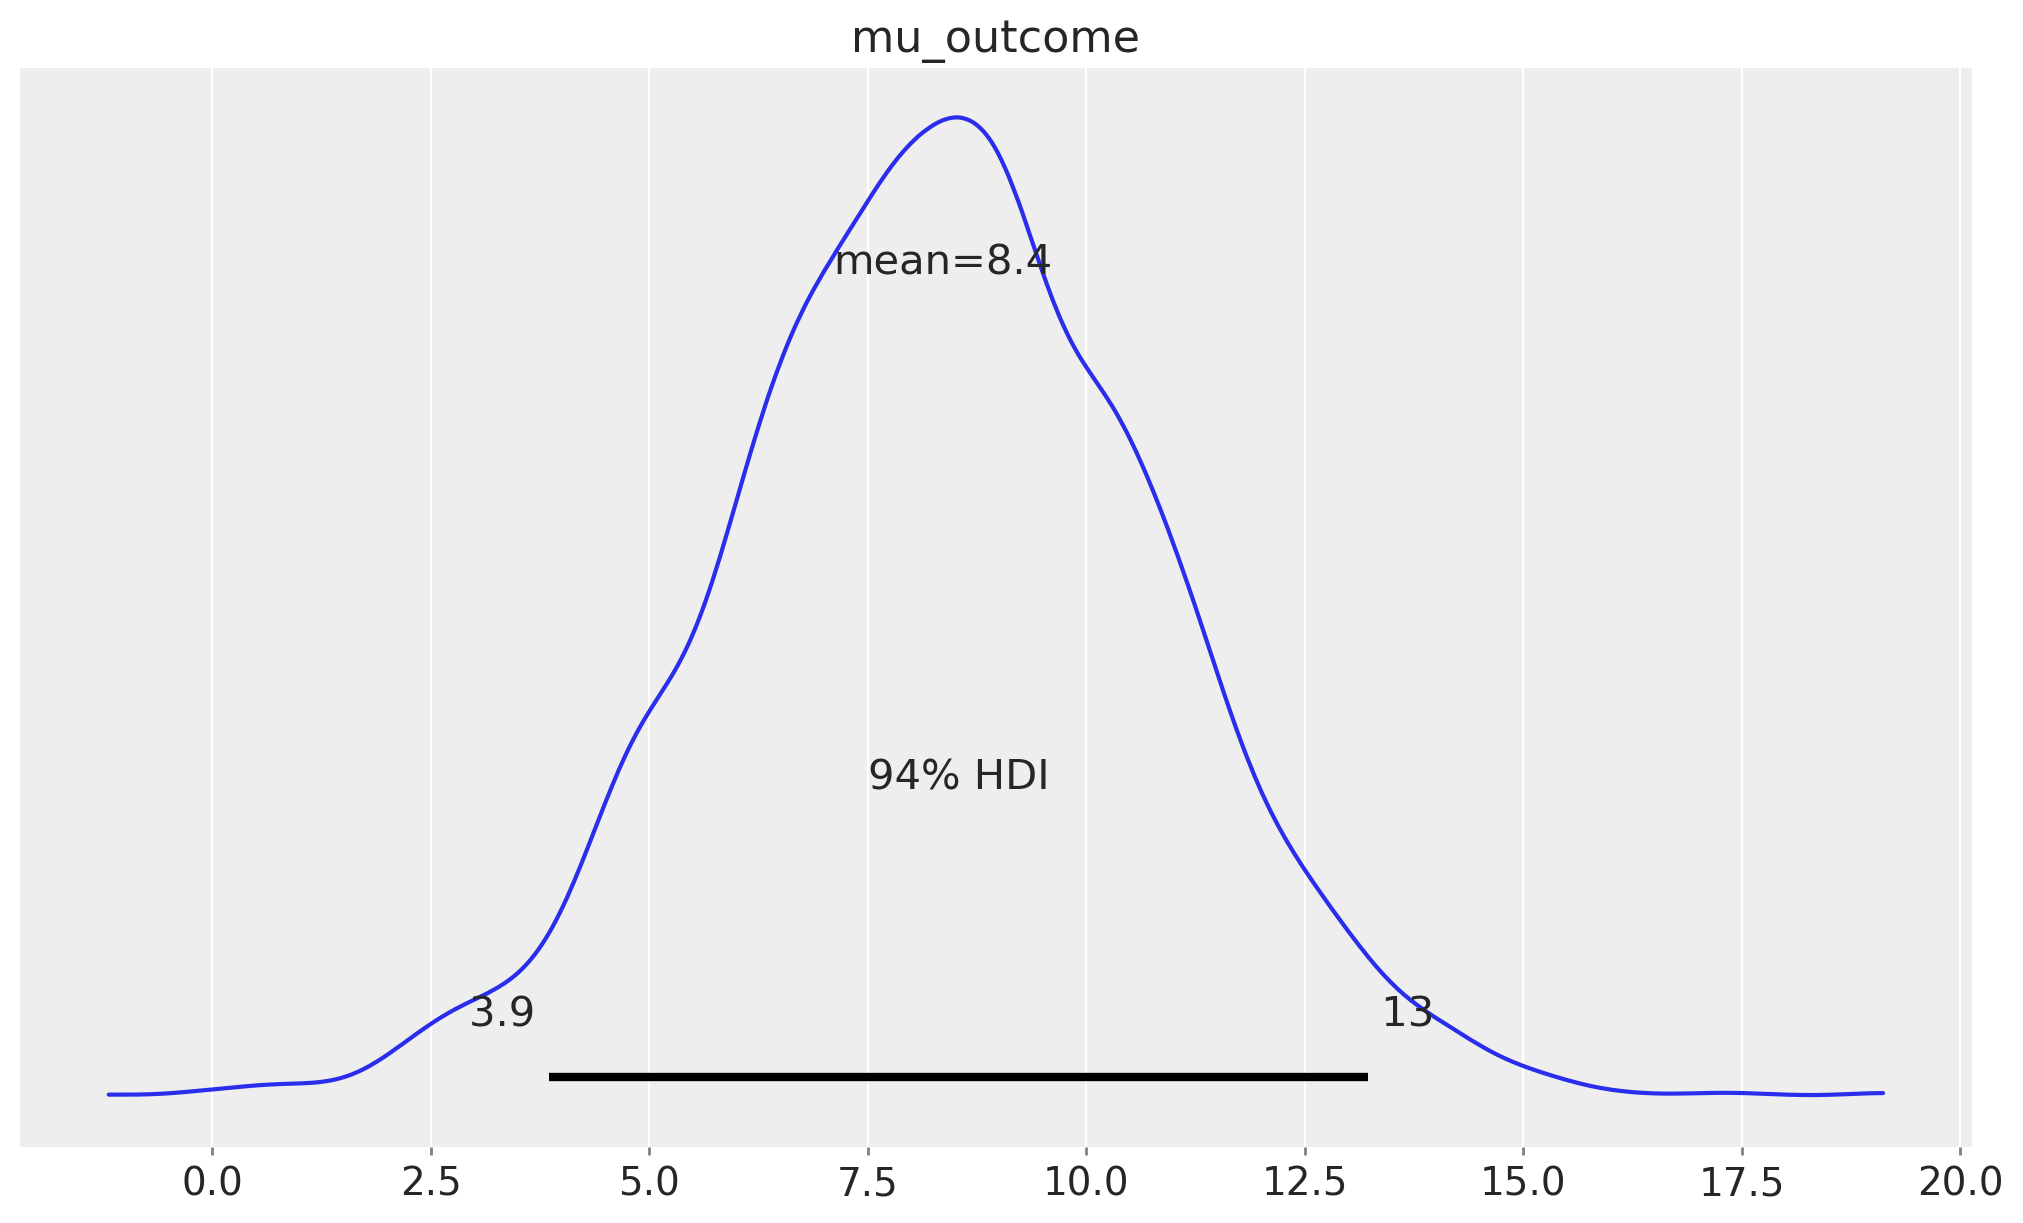

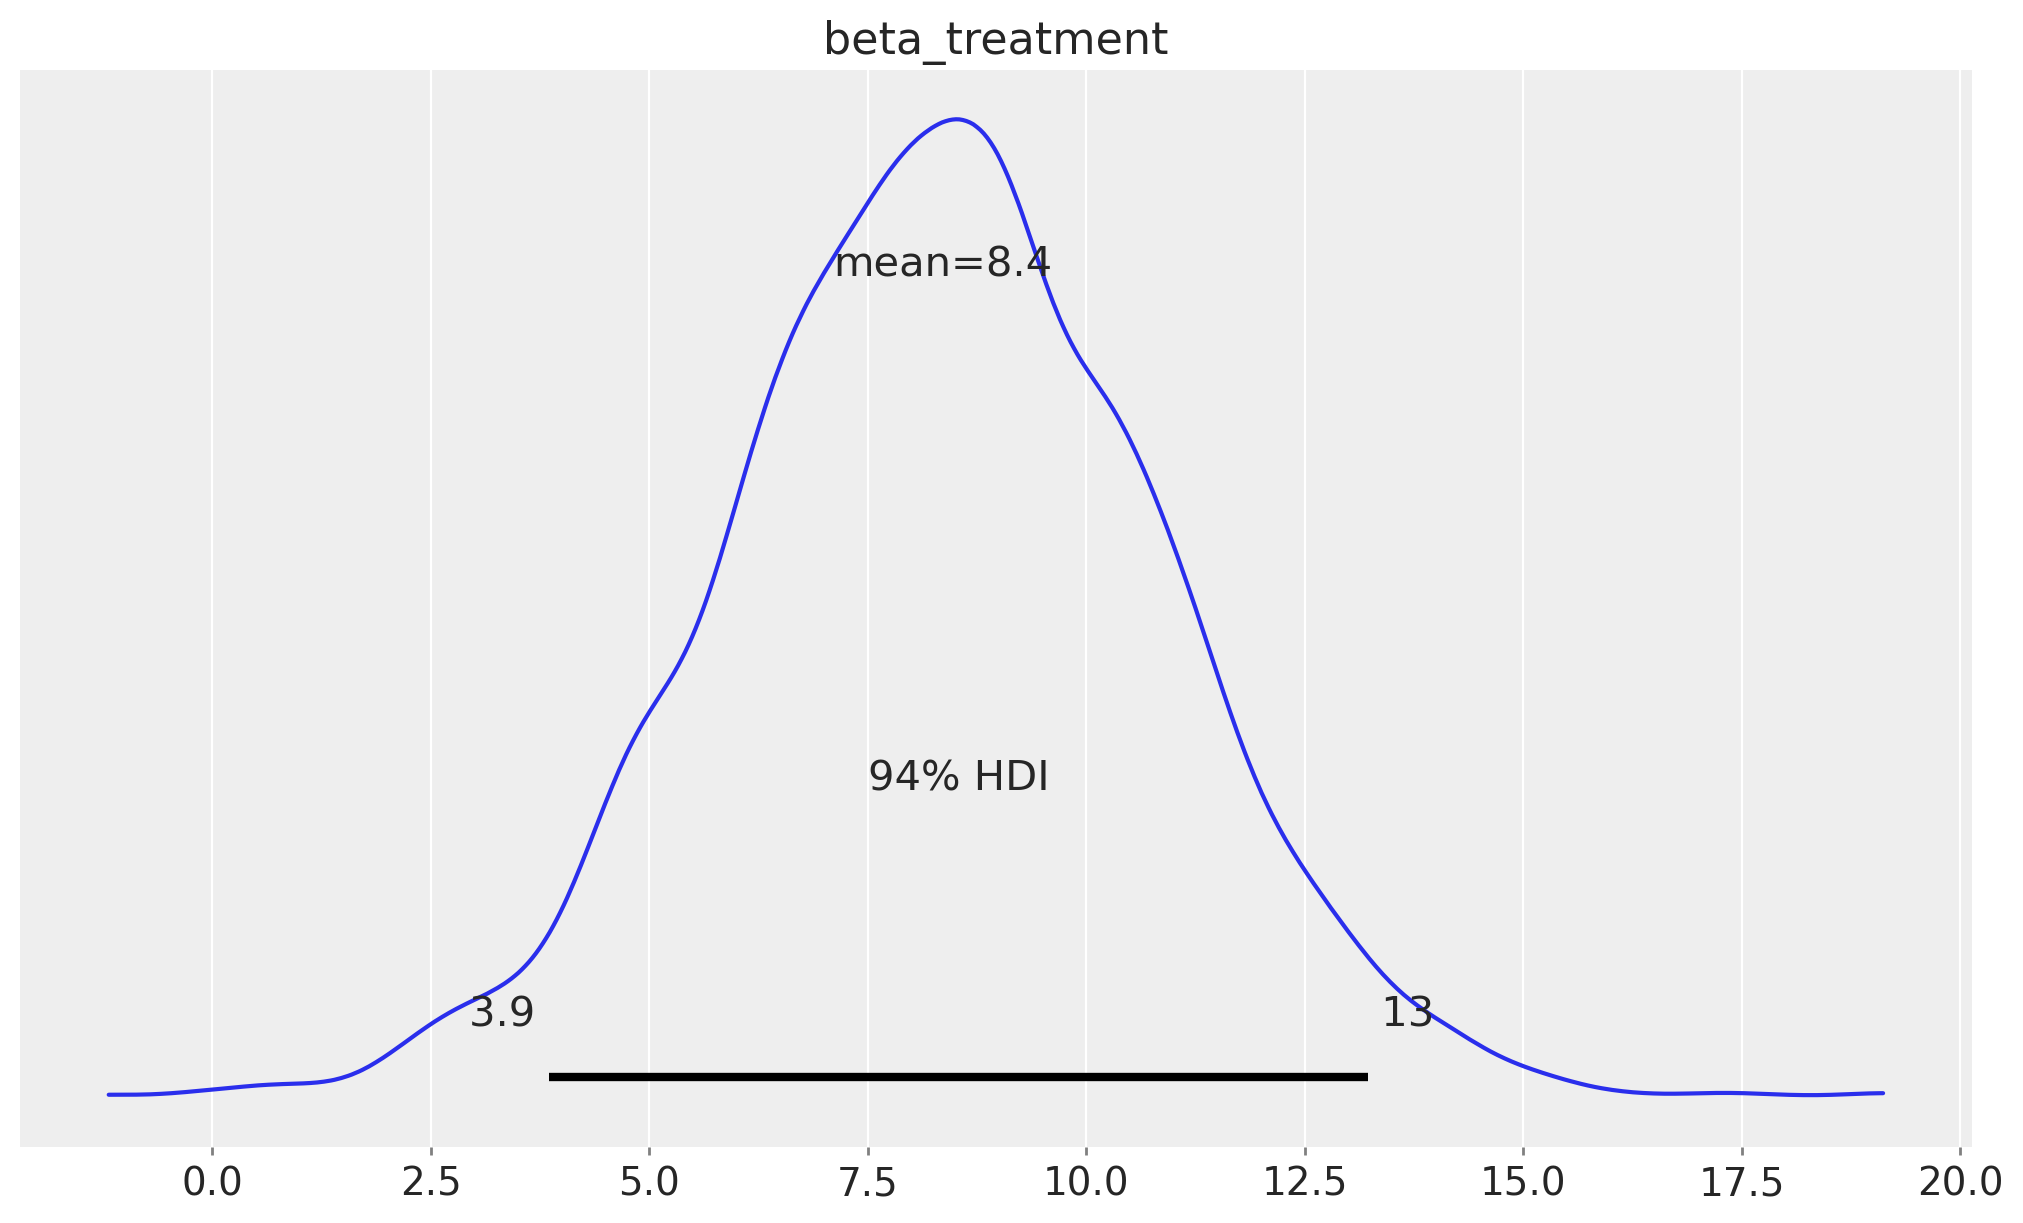

In [20]:
az.plot_posterior(
    (
        original_scale_treatment_posterior_grade
        - original_scale_control_posterior_grade
    ).mean(dim=("obs_idx"))
)
az.plot_posterior(
    (
        idata["posterior"]["beta_treatment"]
        * preprocessor["num"].scale_[numeric_features.index("post_test")]
    ).sel(grade=1)
)

## Conclusion

The analysis shows a **positive causal effect** of "The Electric Company" on reading scores.

-   **Effect Size**: The posterior distribution of the difference (Treatment - Control) is consistently positive.
-   **Model Value**: By using a **Hierarchical Intercept Model**, we successfully controlled for the paired design structure.
    -   We respected the clustering (pairs) without burning degrees of freedom on Fixed Effects.
    -   We avoided the bias of pooled regression by accounting for pair-level heterogeneity.
    -   Because treatment was randomized within pairs, our Random Effects assumption is robust (as discussed in *The Effect*).

This example demonstrates how Multilevel Models can be a powerful tool for Causal Inference, bridging the gap between experimental design and efficient statistical estimation.

In [21]:
def vectorized_correlation_matrices(corr_values, size=2):
    n_matrices = corr_values.shape[0]

    # Reshape for broadcasting
    # Use reshape or expand_dims instead of dimshuffle
    corr_expanded = pt.reshape(corr_values, (n_matrices, 1, 1))

    # Create base: all elements are correlation values
    base = corr_expanded * pt.ones((n_matrices, size, size))

    # Create diagonal mask
    diag_mask = pt.eye(size, dtype="bool")

    # Set diagonal to 1
    return pt.where(diag_mask, 1.0, base)


def vectorized_diagonal_matrices_v4(values):
    k = values.shape[1]  # 2

    # Create identity matrix (2, 2)
    identity_matrix = pt.eye(k)

    # Reshape values for broadcasting: (4, 2) -> (4, 2, 1)
    values_expanded = values[:, :, None]

    # Multiply: (4, 2, 1) * (2, 2) -> (4, 2, 2)
    # This puts values[i, j] at position [i, j, j]
    return values_expanded * identity_matrix

<Axes: >

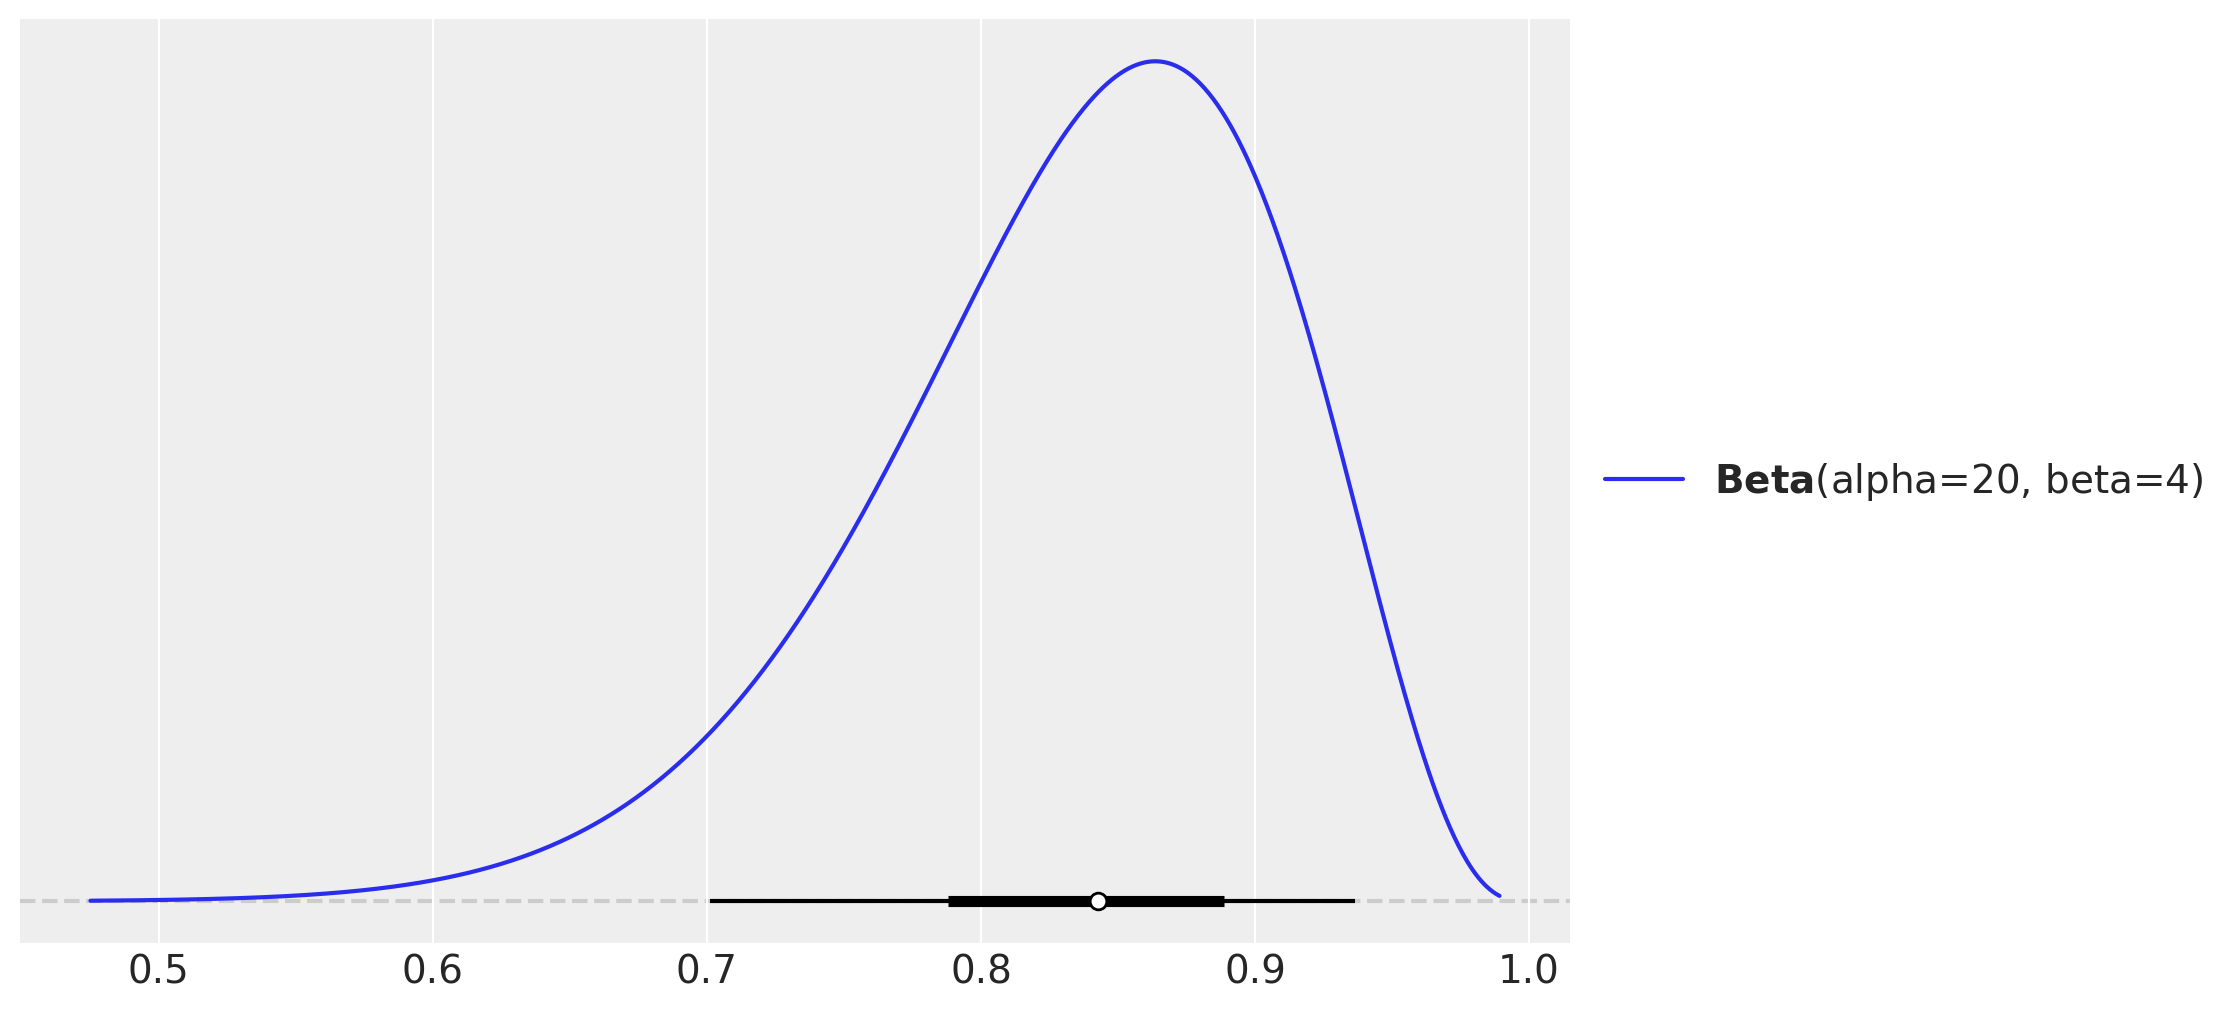

In [22]:
pz.Beta(alpha=20, beta=4).plot_pdf(pointinterval=True)

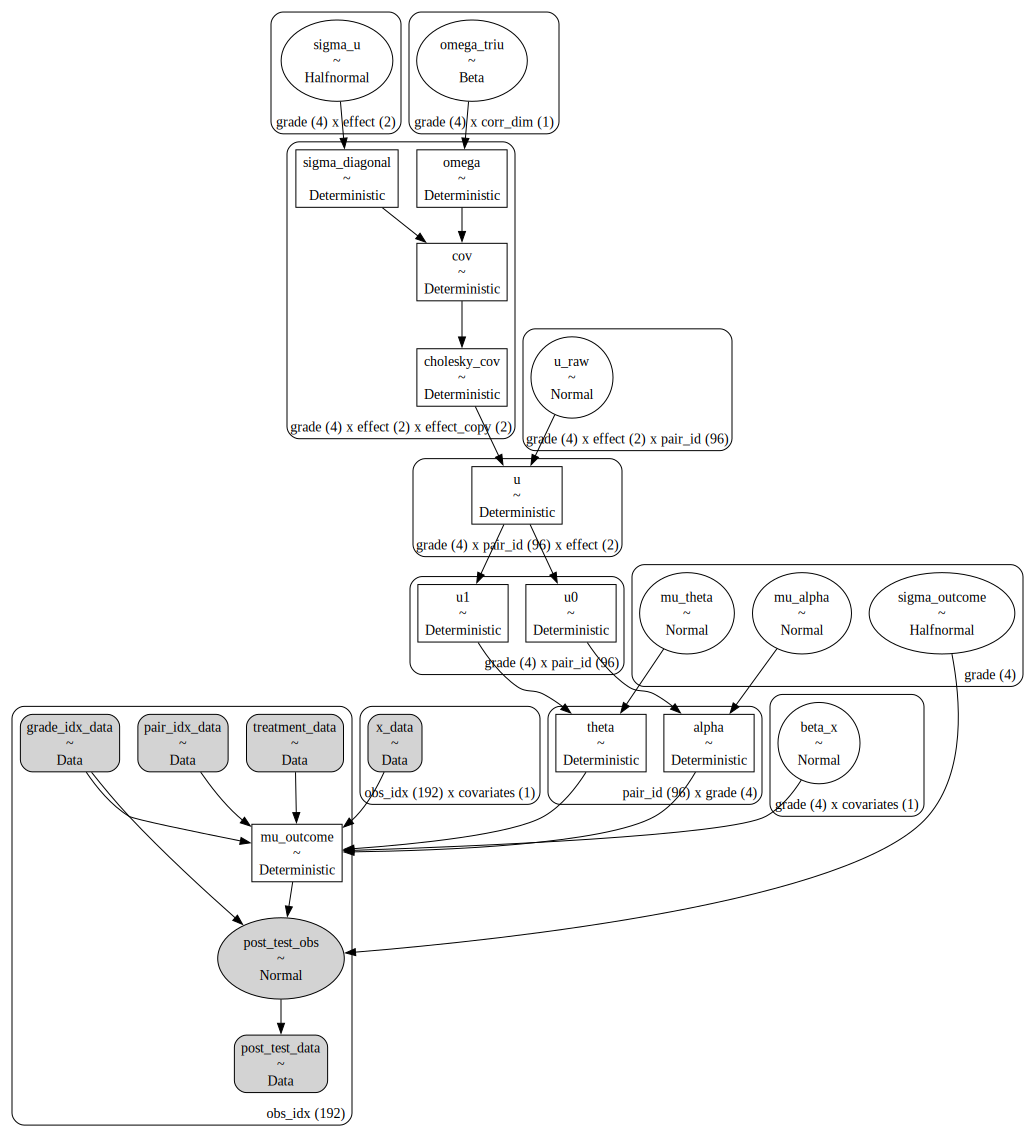

In [23]:
coords.update({"effect": ["intercept", "slope"], "effect_copy": ["intercept", "slope"]})
coords.update({"corr_dim": ["corr_dim_1"]})


with pm.Model(coords=coords) as cov_model:
    # --- Data Containers ---
    # covariates
    x_data = pm.Data("x_data", x_df, dims=("obs_idx", "covariates"))
    # grade
    grade_idx_data = pm.Data("grade_idx_data", df["grade"].to_numpy(), dims="obs_idx")
    # object categories
    pair_idx_data = pm.Data("pair_idx_data", df["pair_id"].to_numpy(), dims="obs_idx")
    # treatment
    treatment_data = pm.Data(
        "treatment_data", df["treatment"].to_numpy(), dims=("obs_idx")
    )
    # outcome
    post_test_data = pm.Data(
        "post_test_data", df["post_test"].to_numpy(), dims="obs_idx"
    )

    # --- Priors ---

    beta_x = pm.Normal("beta_x", mu=0, sigma=1, dims=("grade", "covariates"))
    sigma_outcome = pm.HalfNormal("sigma_outcome", sigma=1, dims=("grade"))

    mu_alpha = pm.Normal("mu_alpha", mu=0, sigma=0.5, dims=("grade"))
    mu_theta = pm.Normal("mu_theta", mu=0, sigma=0.5, dims=("grade"))

    # Group-level standard deviations
    sigma_u = pm.HalfNormal(
        "sigma_u", sigma=np.array([0.2, 0.2]), dims=("grade", "effect")
    )

    # Triangular upper part of the correlation matrix
    # omega_triu = pm.LKJCorr("omega_triu", eta=1, n=2, dims=("grade", "corr_dim"))
    omega_triu = pm.Beta("omega_triu", alpha=20, beta=4, dims=("grade", "corr_dim"))
    omega_triu_scaled = omega_triu * 2 - 1

    # Construct correlation matrix
    omega = pm.Deterministic(
        "omega",
        vectorized_correlation_matrices(omega_triu_scaled),
        dims=("grade", "effect", "effect_copy"),
    )

    # Construct diagonal matrix of standard deviation
    sigma_diagonal = pm.Deterministic(
        "sigma_diagonal",
        vectorized_diagonal_matrices_v4(sigma_u),
        dims=("grade", "effect", "effect_copy"),
    )

    # Compute covariance matrix
    cov = pm.Deterministic(
        "cov",
        pt.einsum("bij,bjk,bkl->bil", sigma_diagonal, omega, sigma_diagonal),
        dims=("grade", "effect", "effect_copy"),
    )

    # Cholesky decomposition of covariance matrix
    cholesky_cov = pm.Deterministic(
        "cholesky_cov",
        pt.slinalg.cholesky(cov),
        dims=("grade", "effect", "effect_copy"),
    )

    # And finally get group-specific coefficients
    u_raw = pm.Normal("u_raw", mu=0, sigma=1, dims=("grade", "effect", "pair_id"))
    u = pm.Deterministic(
        "u",
        pt.einsum("bik,bkj->bji", cholesky_cov, u_raw),
        dims=("grade", "pair_id", "effect"),
    )

    u0 = pm.Deterministic("u0", u[:, :, 0], dims=("grade", "pair_id"))
    u1 = pm.Deterministic("u1", u[:, :, 1], dims=("grade", "pair_id"))

    alpha = pm.Deterministic("alpha", mu_alpha + u0.T, dims=("pair_id", "grade"))
    theta = pm.Deterministic("theta", mu_theta + u1.T, dims=("pair_id", "grade"))

    mu_outcome = pm.Deterministic(
        "mu_outcome",
        alpha[pair_idx_data, grade_idx_data]
        + theta[pair_idx_data, grade_idx_data] * treatment_data
        + (beta_x[grade_idx_data] * x_data).sum(axis=-1),
        dims=("obs_idx"),
    )

    # --- Likelihood ---
    pm.Normal(
        "post_test_obs",
        mu=mu_outcome,
        sigma=sigma_outcome[grade_idx_data],
        observed=post_test_data,
        dims="obs_idx",
    )

pm.model_to_graphviz(cov_model)

In [24]:
with cov_model:
    cov_idata = pm.sample_prior_predictive()

Sampling: [beta_x, mu_alpha, mu_theta, omega_triu, post_test_obs, sigma_outcome, sigma_u, u_raw]


Text(0.5, 1.02, 'Prior Predictive Check - Covariance Model')

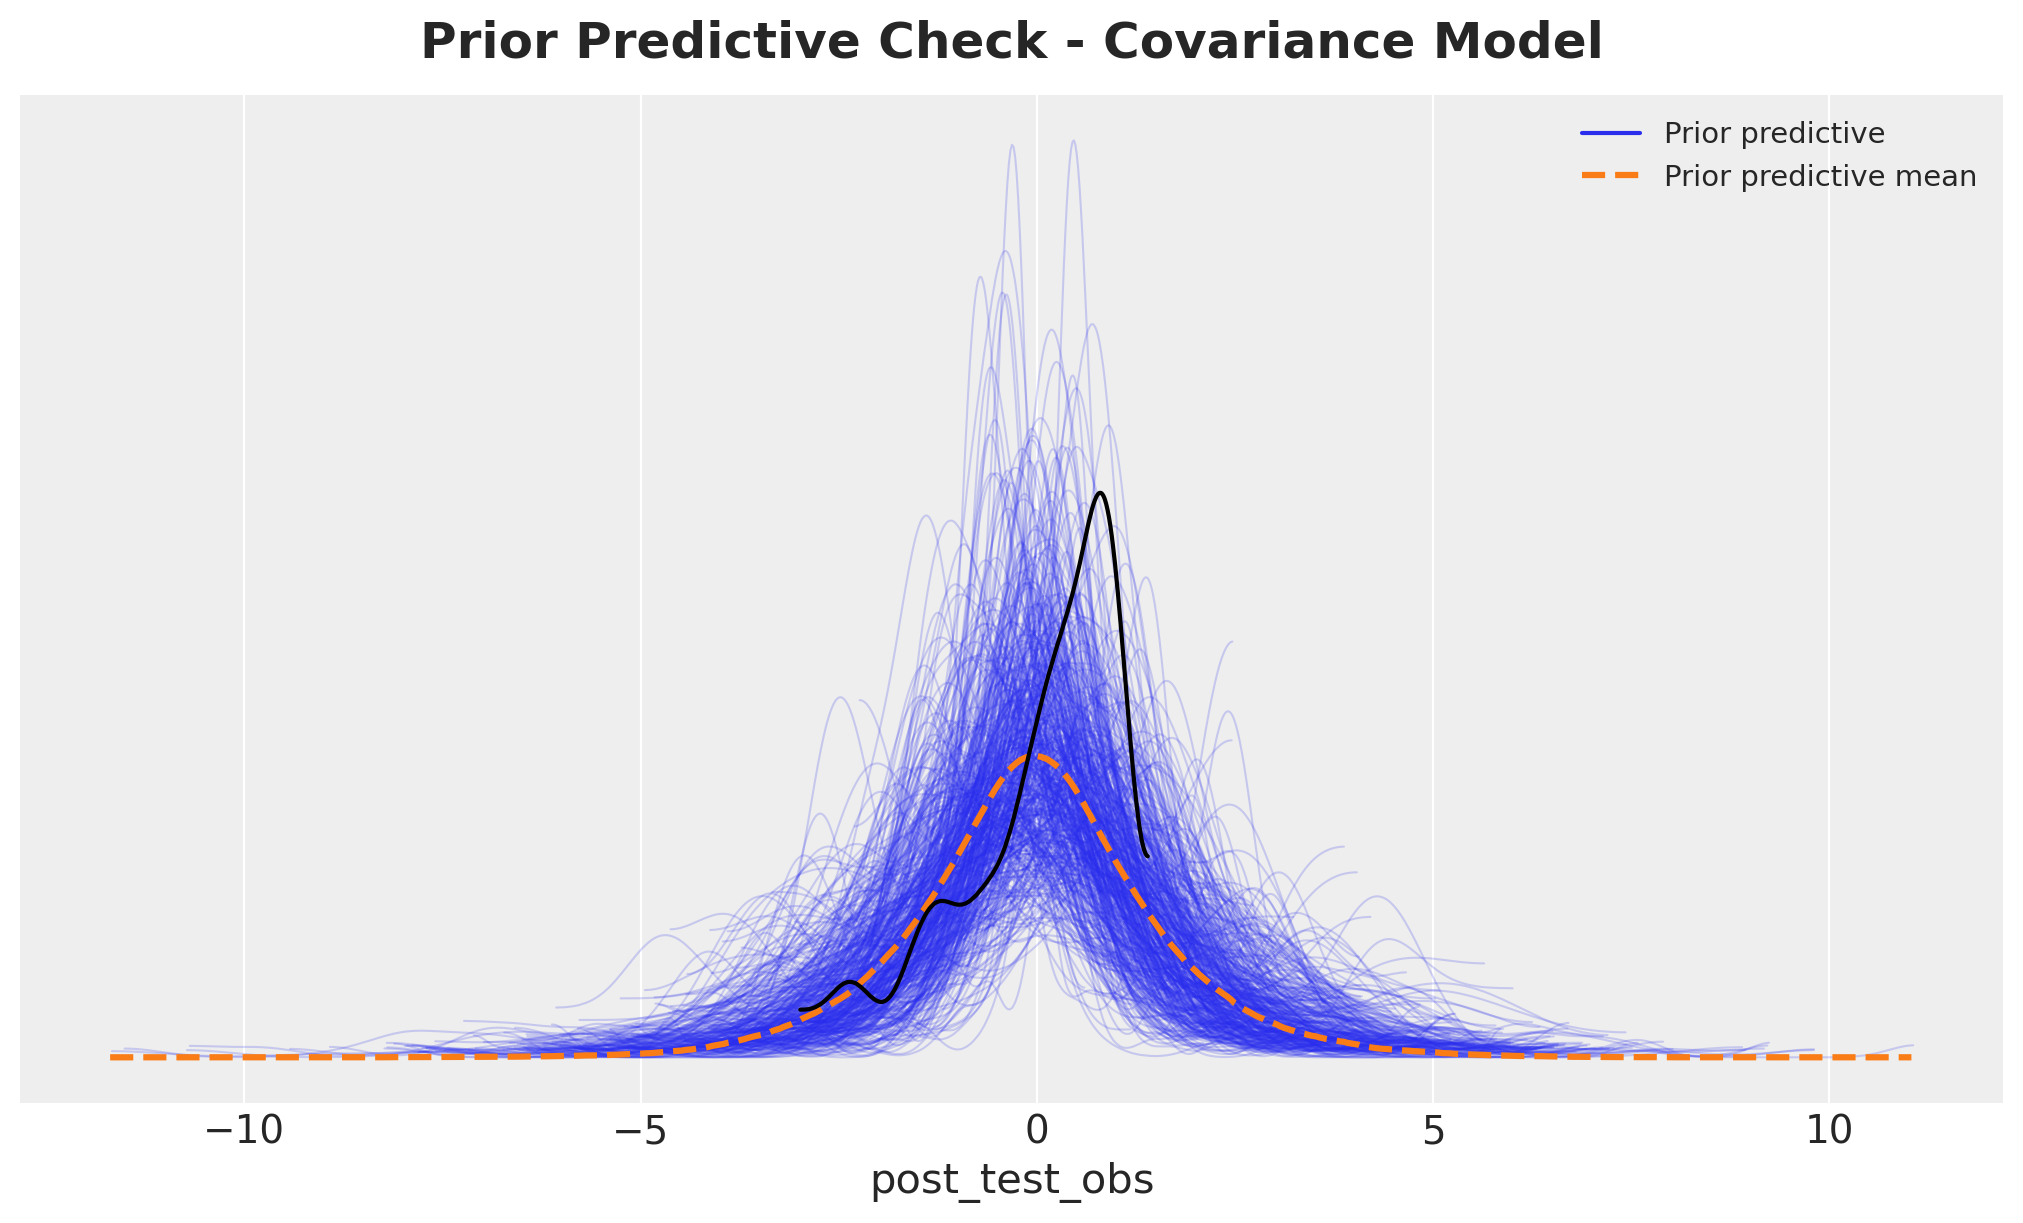

In [25]:
fig, ax = plt.subplots()
az.plot_ppc(cov_idata, group="prior", ax=ax)
az.plot_dist(df["post_test"].to_numpy(), color="black", ax=ax)
ax.set_title(
    "Prior Predictive Check - Covariance Model", fontsize=18, fontweight="bold", y=1.02
)

In [26]:
with cov_model:
    cov_idata.extend(
        pm.sample(
            tune=2_000,
            draws=1_000,
            chains=4,
            nuts_sampler="numpyro",
            target_accept=0.95,
        )
    )

    cov_idata.extend(pm.sample_posterior_predictive(cov_idata))

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling: [post_test_obs]


Output()

In [27]:
# az.summary(
#     slopes_idata,
#     var_names=[
#         "beta_x",
#         "mu_alpha",
#         "sigma_alpha",
#         "mu_treatment",
#         "sigma_treatment",
#         "sigma_outcome",
#     ],
# )

In [28]:
cov_idata["sample_stats"]["diverging"].sum().item()

0

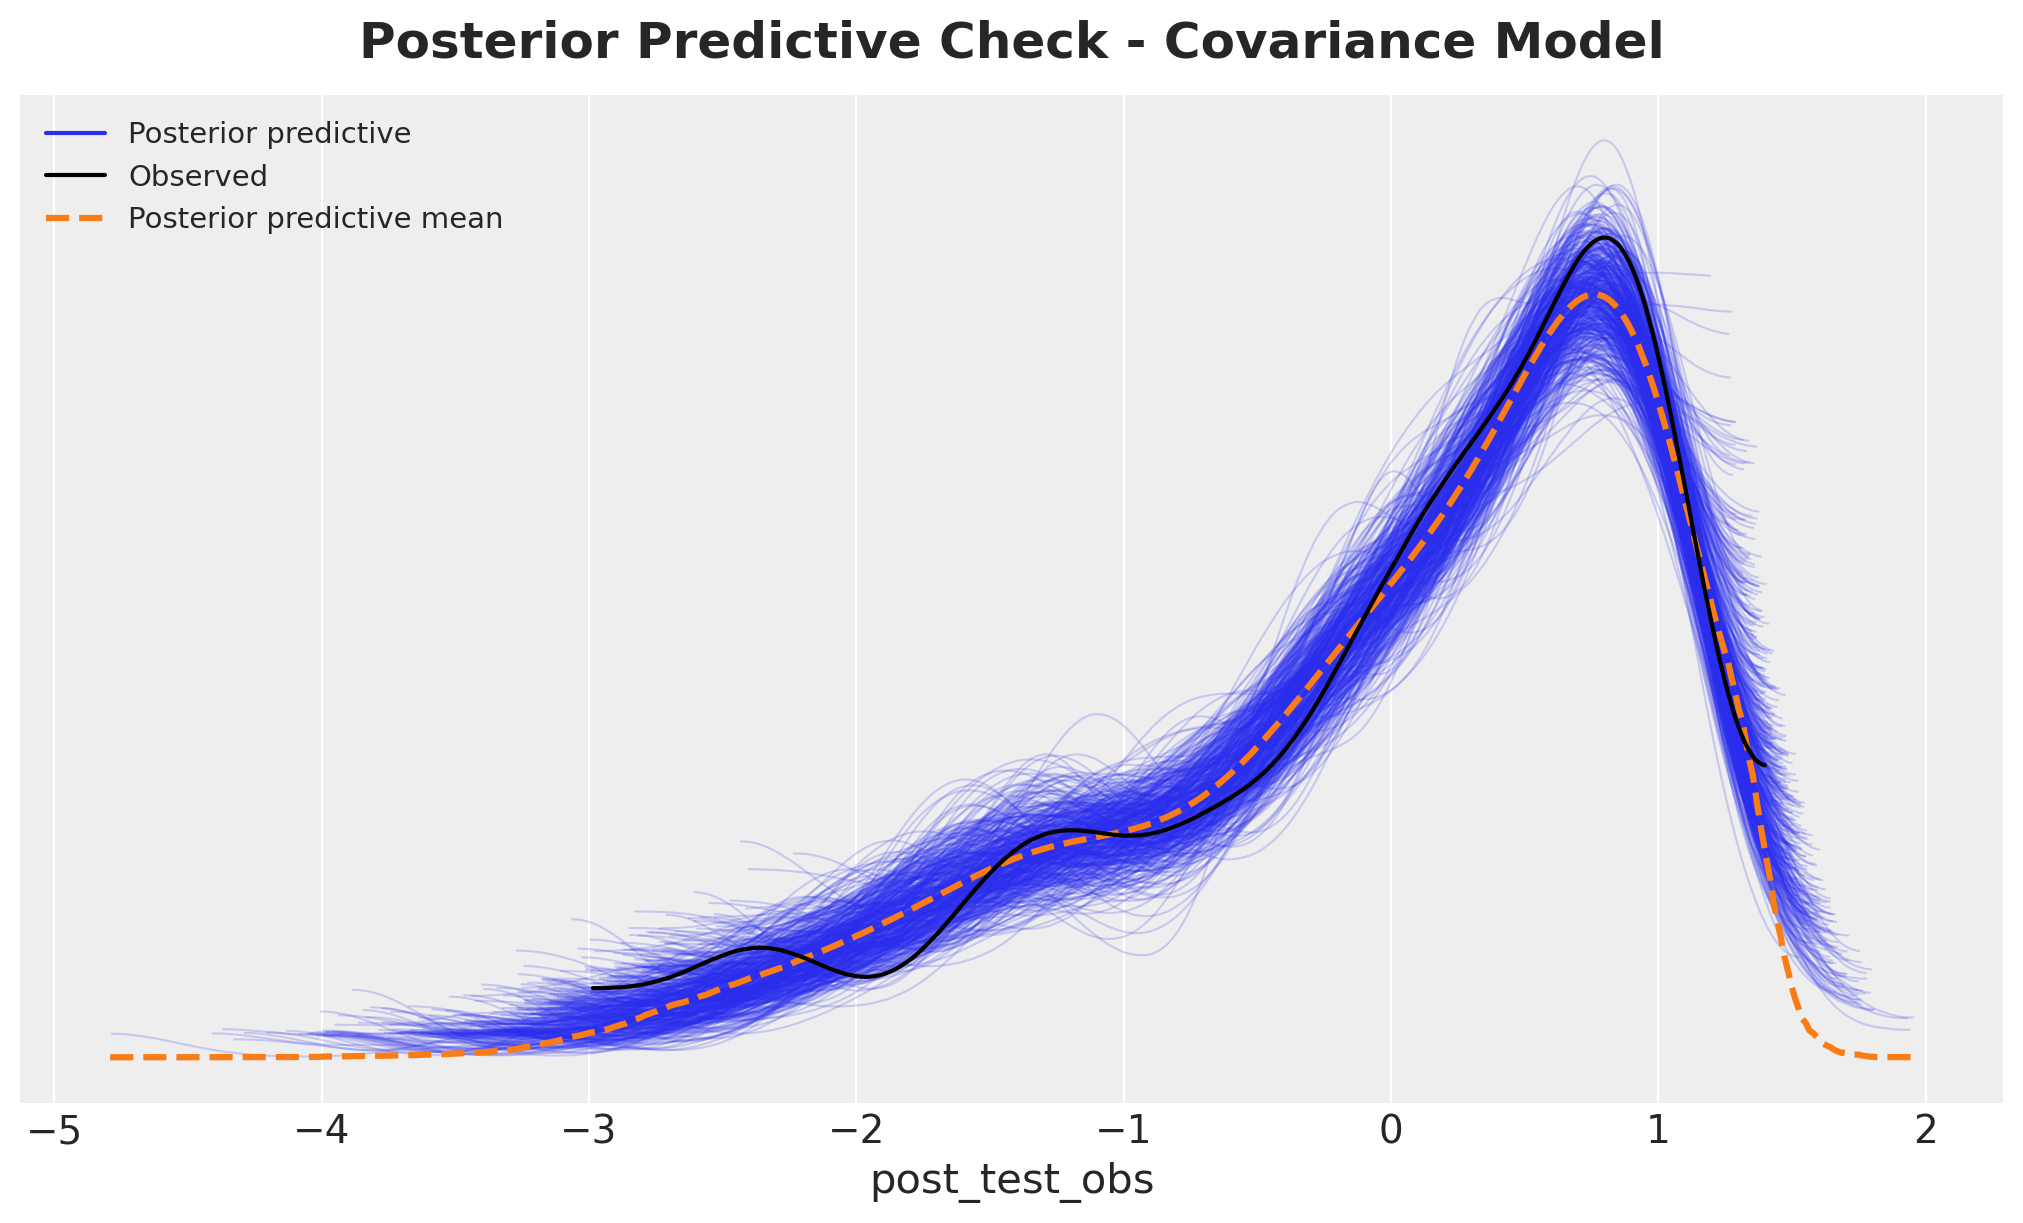

In [29]:
fig, ax = plt.subplots()
az.plot_ppc(cov_idata, group="posterior", num_pp_samples=500, ax=ax)
ax.set_title(
    "Posterior Predictive Check - Covariance Model",
    fontsize=18,
    fontweight="bold",
    y=1.02,
);

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

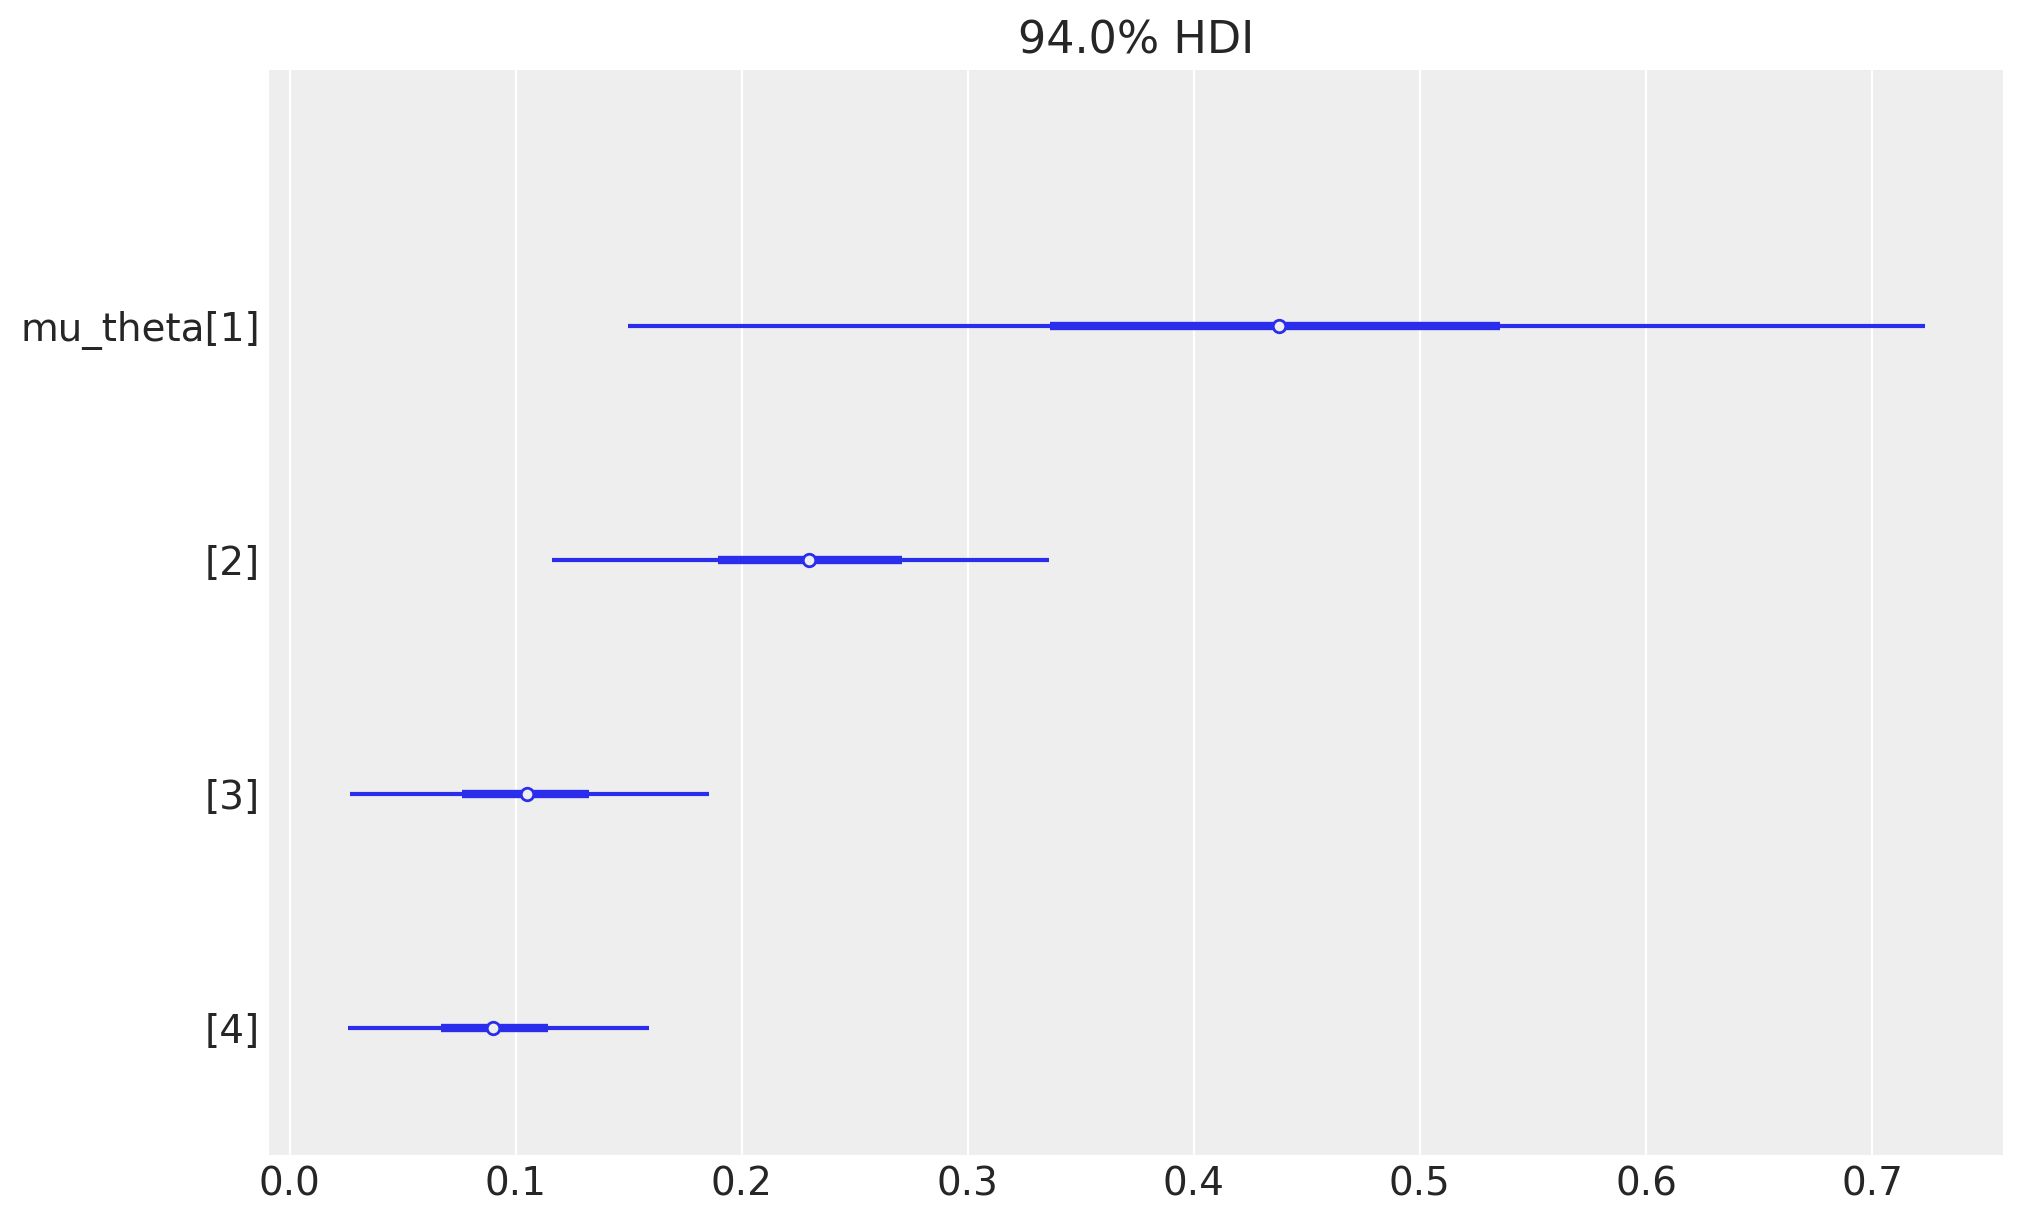

In [30]:
fig, ax = plt.subplots()
az.plot_forest(
    cov_idata,
    combined=True,
    var_names=["mu_theta"],
    ax=ax,
)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

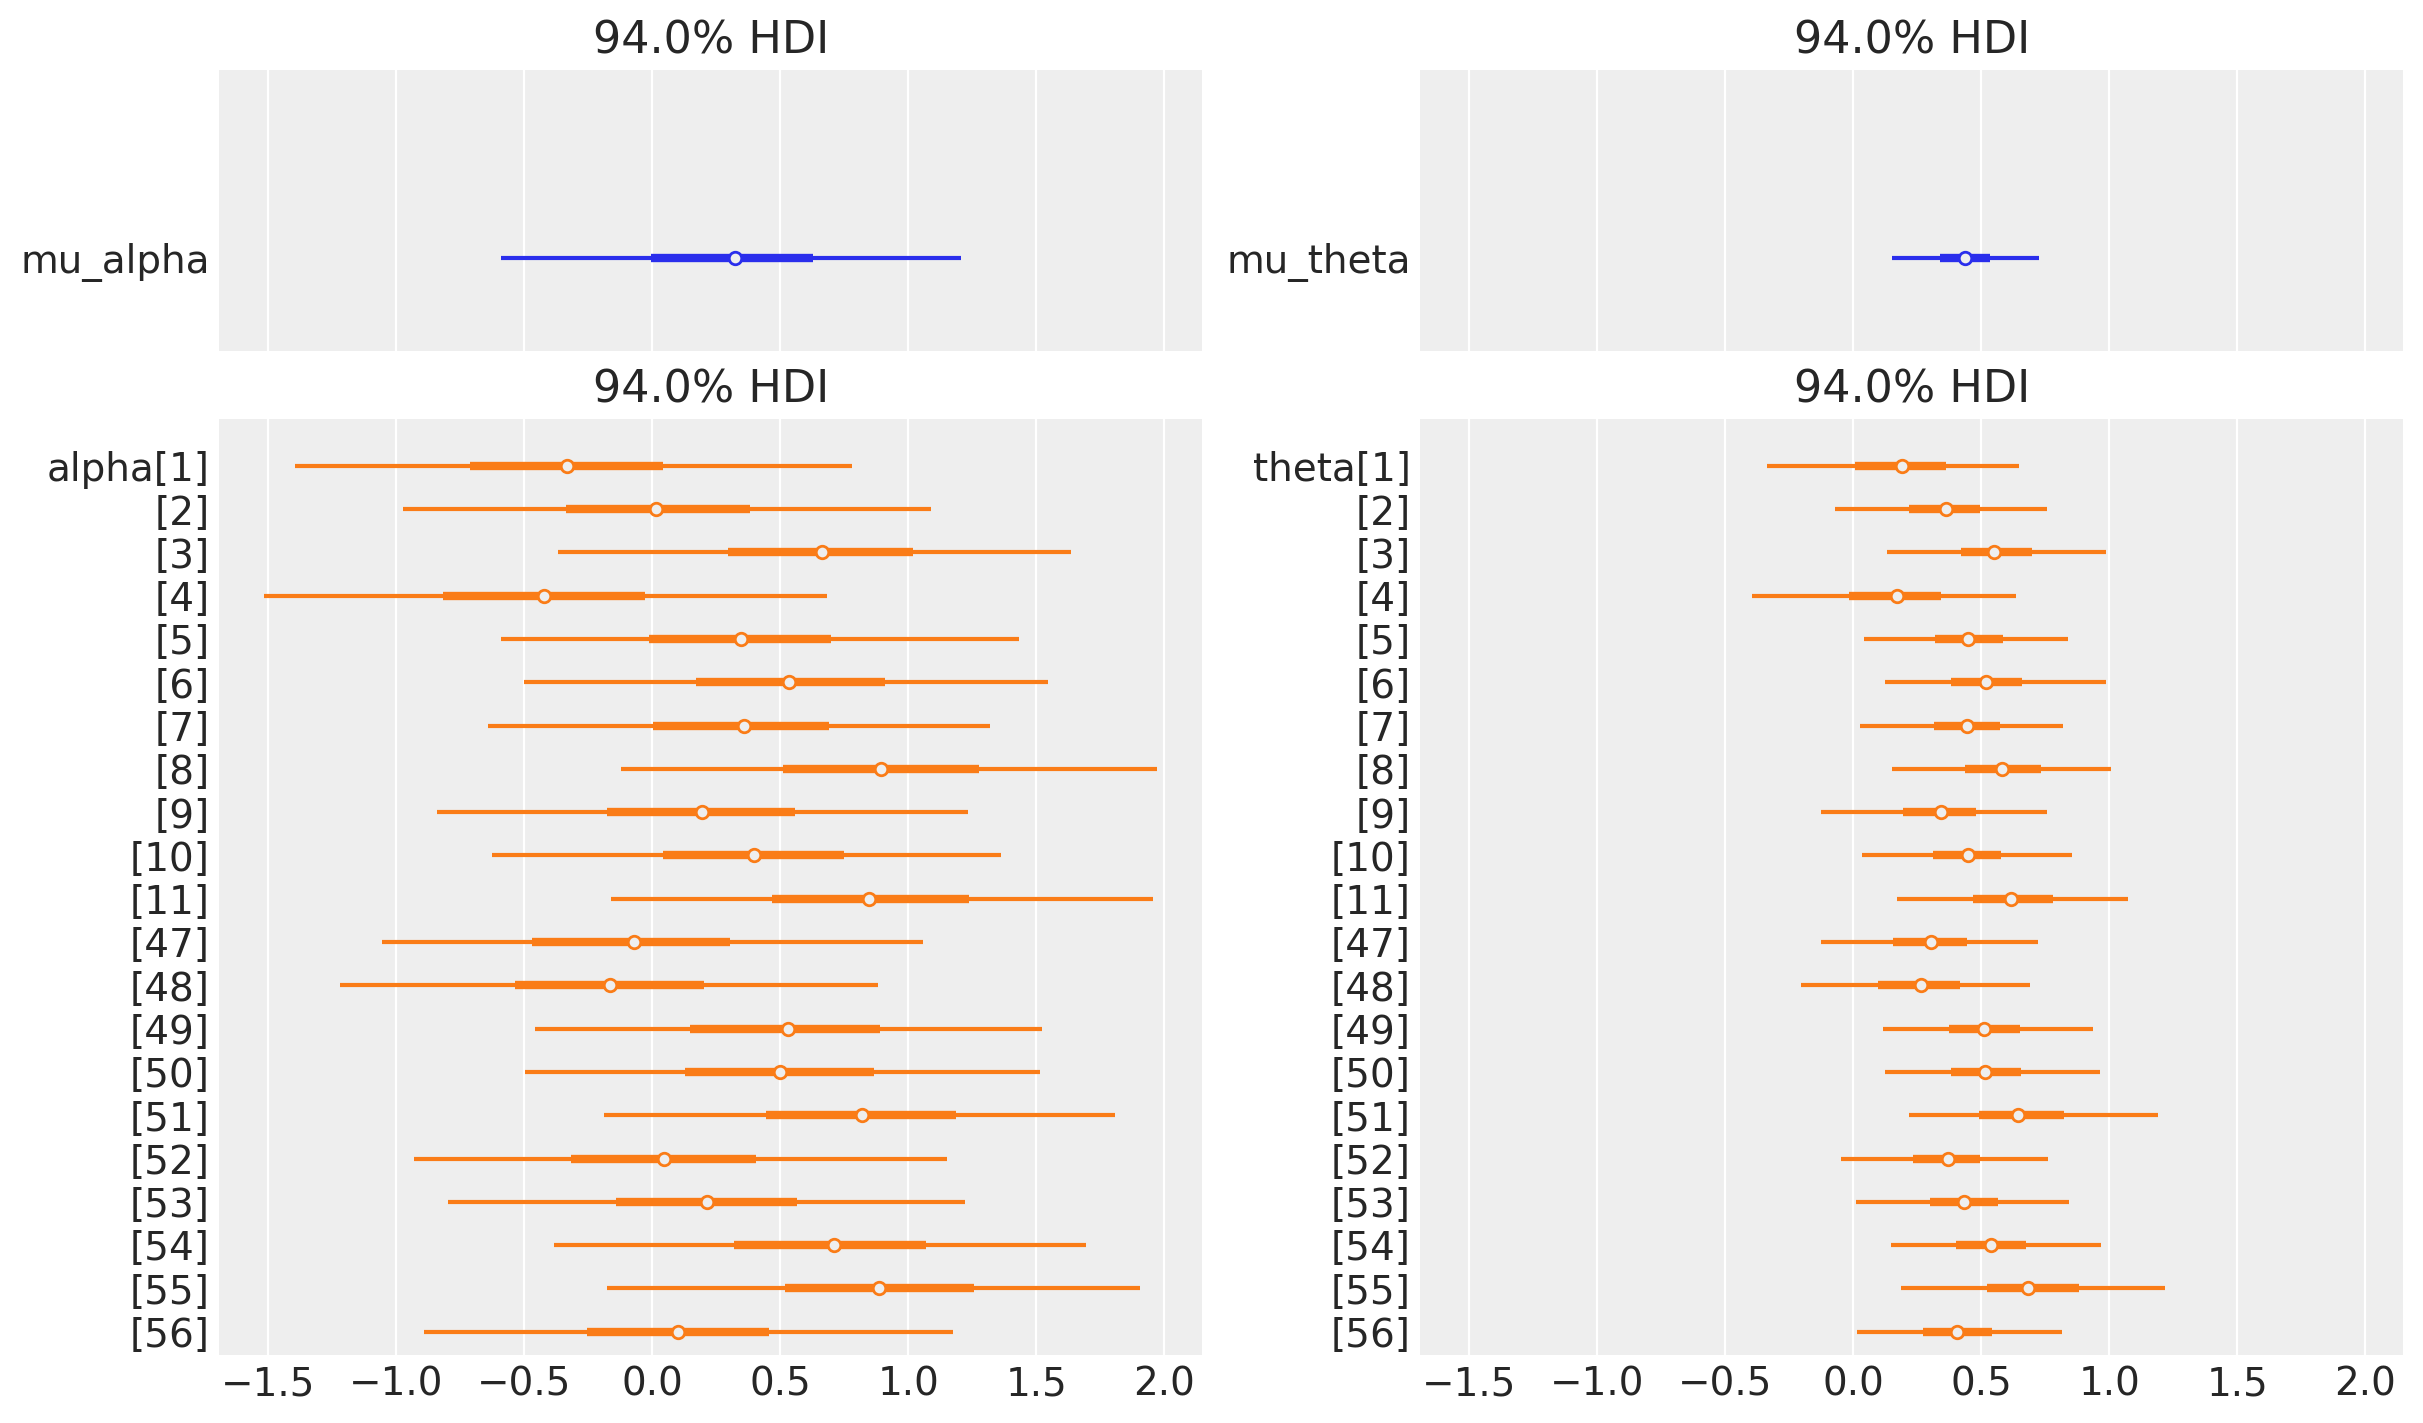

In [35]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    height_ratios=[0.3, 1],
    figsize=(12, 7),
    sharex=True,
    sharey=False,
    layout="constrained",
)

az.plot_forest(
    cov_idata["posterior"].sel(grade=1),
    combined=True,
    var_names=["mu_alpha"],
    colors="C0",
    ax=ax[0, 0],
)


az.plot_forest(
    cov_idata["posterior"]
    .sel(grade=1)
    .where(
        cov_idata["posterior"].pair_id.isin(
            raw_df.group_by("grade")
            .agg(pl.col("pair_id").unique())
            .filter(pl.col("grade").eq(pl.lit(1)))["pair_id"]
            .to_list()
        ),
        drop=True,
    ),
    var_names=["alpha"],
    combined=True,
    colors="C1",
    ax=ax[1, 0],
)


az.plot_forest(
    cov_idata["posterior"].sel(grade=1),
    combined=True,
    var_names=["mu_theta"],
    colors="C0",
    ax=ax[0, 1],
)


az.plot_forest(
    cov_idata["posterior"]
    .sel(grade=1)
    .where(
        cov_idata["posterior"].pair_id.isin(
            raw_df.group_by("grade")
            .agg(pl.col("pair_id").unique())
            .filter(pl.col("grade").eq(pl.lit(1)))["pair_id"]
            .to_list()
        ),
        drop=True,
    ),
    var_names=["theta"],
    combined=True,
    colors="C1",
    ax=ax[1, 1],
)